# Diffusion as a Stochastic Process

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [804]:
X = np.zeros((102,102))

In [805]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [806]:
X.shape

(102, 102)

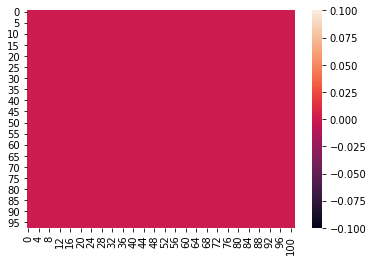

In [807]:
sns.heatmap(X[1:100][1:100])

In [808]:
for i in range(400):
    i,j = np.random.randint(1,101), np.random.randint(1,101)
    X[i][j] = X[i][j] + 1

### Distribucion uniforme

In [1095]:
def dist_uni(d,n):
    X = np.zeros((d + 2,d + 2))
    for i in range(n):
        i,j = np.random.randint(1,d + 1), np.random.randint(1,d + 1)
        X[i][j] = X[i][j] + 1
    return X

In [1096]:
X = dist_uni(100,400)

In [1097]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

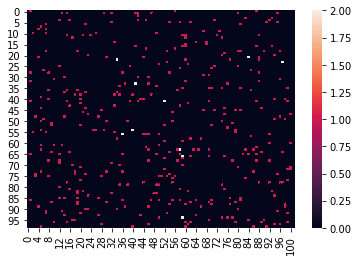

In [1098]:
sns.heatmap(X[1:101][1:101])

### Actualización de Condiciones Periódicas

In [813]:
for j in range(1,101):
    X[0][j] = X[100][j]
    X[101][j] = X[1][j]
    X[j][0] = X[j][100]
    X[j][101] = X[j][1]

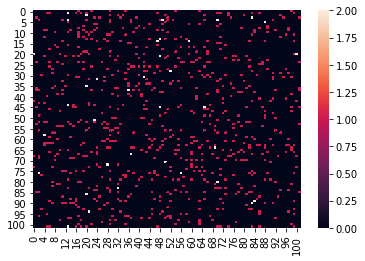

In [814]:
sns.heatmap(X[:][:])

### Ley de Fick

El flujo de partículas es proporcional al gradiente de concentración

$$J(\mathbf{x},t) = - D \nabla c(\mathbf{x}, t)$$

Número de partículas que cruzan, por unidad de área, por unidad de tiempo. Entonces $A J$ es el número de partículas por unidad de tiempo que están atravesando la "ventana" de tamaño $A$.

Para implementar el algoritmo, debemos calcular la probabilidades por unidad de tiempo de moverse las partículas a regiones contiguas. Para ello, usamos una versión discreta de la ley de Fick

$$a(s,d,i,j) =  - A D \frac{\left [X(s,i + 1,j)/L^3 - X(s, i,j)/L^3 \right ]}{L}$$

$$[D] = \frac{L^2}{s}$$

en donde $d$ indica la dirección en la que se movería la partícula, en este caso a la derecha; cada partícula tiene 4 grados de libertad. Esto es, aquí la clave de poder considerar la difusión como un procesos análogo a las reacciones químicas (desde el punto de vista probabilístico), es que cada posibilidad de movimiento es análogo o equivalente a la posibilidad de una transmutación química.


En un espacio de dos dimensiones, hay 4 posibilidades para cada molécula o partícula; hay que ponderarlas todas

In [815]:
D = 1.

In [70]:
a = np.zeros((4,101,101))

### Cálculo de las "propensiones" $a(s,d,i,j)$

In [819]:
for i in range(1,101):
    for j in range(1,101):
        a[0][i][j] = D*(X[i][j] - X[i - 1][j])
        if a[0][i][j] < 0:
            a[0][i][j] = 0
        a[1][i][j] = D*(X[i][j] - X[i + 1][j])
        if a[1][i][j] < 0:
            a[1][i][j] = 0
        a[2][i][j] = D*(X[i][j] - X[i][j - 1])
        if a[2][i][j] < 0:
            a[2][i][j] = 0
        a[3][i][j] = D*(X[i][j] - X[i - 1][j + 1])
        if a[3][i][j] < 0:
            a[3][i][j] = 0

### Rutina Montecarlo para el algoritmo de Gillespie

$$P(\tau, \mu, i, j) = a(\mu, i, j)\, \exp{-[\sum_{\mu i j} a(\mu, i ,j)] \tau ]}$$

$$P(\tau, \mu, i, j) = P_1(\tau) P_2(\mu, i, j| \tau)$$

$$P_1(\tau)= \exp{-[\sum_{\mu i j} a(\mu, i ,j)] \tau ]}  \sum_{\mu i j} a(\mu, i, j)$$

$$P_2(\mu, i, j| \tau) = \frac{a( \mu, i, j)}{\sum_{\mu i j} a(\mu, i, j)}$$

$$P_3(\mu |\tau) = \sum_{i j} P_2(\mu, i, j | \tau) = \frac{\sum_{i j} a( \mu, i, j)}{\sum_{\mu i j} a(\mu, i, j)}$$


$$P_4(i |\tau, \mu) = \sum_{j} P_2(\mu* ,i,j|\tau) = \sum_{j} \left [\frac{a(\mu,i,j)}{\sum_{\mu, i, j} a(\mu,i,j)}   \right ]$$

$$P_5(j |\tau, \mu, i*) = \sum_{i} P_2(\mu*,i*,j|\tau) = \sum_{i} \left [\frac{a(\mu*,i*,j)}{\sum_{\mu, i, j} a(\mu,i,j)}   \right ]$$

In [818]:
P2 = np.zeros((4,101,101))
P3 = np.zeros((4))
P4 = np.zeros((4,101))
P5 = np.zeros((4,101))

In [911]:
def fun_a0(a, d):
    a0 = 0
    for mu in range(0,4):
        for i in range(1,d + 1):
            for j in range(1,d + 1):
                a0 = a0 + a[mu][i][j]
    return a0

In [912]:
fun_a0(a, 100)

230.0

### Función de  actualización de las propoensiones $a(\mu, i, j)$

In [913]:
def actualizacion_as(a, X, d):
    for i in range(1,d + 1):
        for j in range(1,d + 1):
            a[0][i][j] =  D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] =  D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] =  D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] =  D*(X[i][j] - X[i][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
    return a

In [566]:
for mu in range(4):
    for i in range(1,101):
        for j in range(1,101):
            P2[mu][i][j] = a[d][i][j]/a0

In [92]:
for mu in range(4):
    suma_mu = 0
    for i in range(1,101):
        for j in range(1,101):
            suma_mu = suma_mu + P2[mu][i][j]
    P3[mu] = suma_mu

In [96]:
for mu in range(4):
    for i in range(1,101):
        suma_j = 0
        for j in range(1,101):
            suma_j = suma_j + P2[mu,i,j]
        P4[mu][i] = suma_j

In [97]:
for mu in range(4):
    for j in range(1,101):
        suma_i = 0
        for i in range(1,101):
            suma_i = suma_i + P2[mu,i,j]
        P5[mu][j] = suma_i

### Función que actualiza las probabilidades

## Aquí está el problema...

**Las probabilidades $P_4$ y $P_5$ no pueden calcularse hasta que ya se han definido $\mu$ e $i$ respectivamente**

In [989]:
def act_probs(a, a0, P2, P3, d):

    for mu in range(4):
        for i in range(1,d + 1):
            for j in range(1,d + 1):
                P2[mu][i][j] = a[mu][i][j]/a0
                
    for mu in range(4):
        suma_mu = 0
        for i in range(1,d + 1):
            for j in range(1,d + 1):
                suma_mu = suma_mu + P2[mu][i][j]
        P3[mu] = suma_mu
        
#    for mu in range(4):
#        for i in range(1,d + 1):
#            suma_j = 0
#            for j in range(1,d + 1):
#                suma_j = suma_j + P2[mu,i,j]
#            P4[mu][i] = suma_j
            
#    for mu in range(4):
#        for j in range(1,d + 1):
#            suma_i = 0
#            for i in range(1,d + 1):
#                suma_i = suma_i + P2[mu,i,j]
#            P5[mu][j] = suma_i
            
    return P2, P3

### Algoritmo de Gillespie generalizado a ambientes anisotrópicos

$$\tau = \frac{1}{a_0} \ln{\left (\frac{1}{r1}\right )}$$

$$\sum_{\nu=1}^{\mu -1} P_3(\nu|\tau) < r2 \le \sum_{\nu=1}^{\mu} P_3(\nu|\tau)$$


$$\sum_{i=1}^{i* -1} P_4(\nu, i|\tau) < r3*P_3(\mu |\tau) \le \sum_{i = 1}^{i*} P_3(\mu, i|\tau)$$


$$\sum_{j=1}^{j* -1} P_5(\nu, j|\tau) < r4*P_4(i |\tau, \mu) \le \sum_{j = 1}^{j*} P_5(\mu, j|\tau)$$

Tenemos que elegir un cuarteto de números $\tau$, el intervalo de tiempo, $\mu$ el procesos (reacción-difusión), $i$ el renglón en la mala y $j$ la columna en la malla.

### Funciones del algoritmo de Gillespie que generan el cuarteto de números para actualizar

In [992]:
def fun_mu(P3,r2):
    suma_mu = 0.
    for nu in range(4):
        #print('P3[mu]', P3[nu],'nu',nu)
        suma_mu = suma_mu + P3[nu]
        #print('Suma_mu', suma_mu,'r2',r2)
        if suma_mu >= r2:
            return nu
    return nu

In [1028]:
def fun_i(P3,P4,r3,mu,d):
    suma_i = 0
    for i_star in range(1,d + 1):
        suma_i = suma_i + P4[i_star]
        if suma_i >= r3*P3[mu]:
            return i_star
    return i_star

In [1032]:
def fun_j(P4,r4,mu,i,d):
    suma_j = 0.
    for j_star in range(1,d + 1):
        suma_j = suma_j + P2[mu][i][j_star]
        if suma_j >= r4*(P4[i]):
            return j_star
    return j_star

In [885]:
chosen_mus = [fun_mu(P3,np.random.rand()) for n in range(1000)]

Text(0.5, 1.0, "Distribución de las mu's")

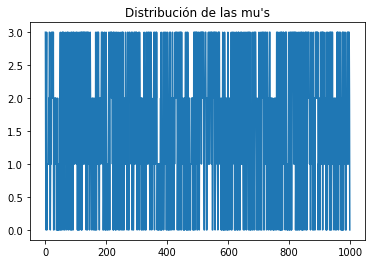

In [886]:
plt.plot(chosen_mus)
plt.title("Distribución de las mu's")

Text(0.5, 1.0, "Distribución de las i's")

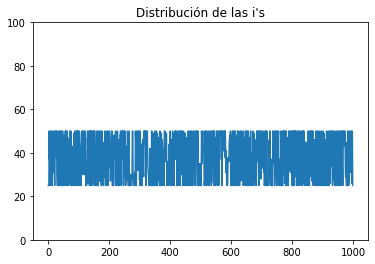

In [889]:
plt.plot([fun_i(P3,P4,np.random.rand(),fun_mu(P3,np.random.rand())) for i in range(1000)])
plt.ylim(0,100)
plt.title("Distribución de las i's")

Text(0.5, 1.0, "Distribución de las j's")

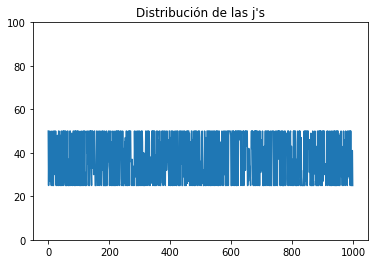

In [890]:
plt.plot([fun_j(P3,P5,np.random.rand(),fun_mu(P3,np.random.rand())) for i in range(1000)])
plt.ylim(0,100)
plt.title("Distribución de las j's")

### Actualizacion de la matriz de concentracion

In [1044]:
def fun_act_dif(X, mu, i, j, d):
    # Difusion hacia arriba
    if mu == 0:
        X[i,j] = X[i,j] - 1
        X[i - 1, j] = X[i - 1, j] + 1
        if i == 1:
            X[d, j] = X[d, j] + 1
    # Difusion hacia abajo    
    elif mu == 1:
        X[i,j] = X[i,j] - 1
        X[i + 1, j] = X[i + 1, j] + 1
        if i == d:
            X[1, j] = X[1, j] + 1 
    # Difusion hacia la izquierda
    elif mu == 2:
        X[i,j] = X[i,j] - 1
        X[i,j - 1] = X[i,j - 1] + 1
        if j == 1:
            X[i, d] = X[i, d] + 1
    # Difusion hacia la derecha
    elif mu == 3:
        X[i,j] = X[i,j] - 1
        X[i,j + 1] = X[i,j + 1] + 1
        if j == d:
            X[i,1] = X[i,1] + 1
    return X

In [1033]:
def paso_montecarlo(X, a, t, P2, P3, d):
    
    r1 = np.random.rand()
    r2 = np.random.rand()
    r3 = np.random.rand()
    r4 = np.random.rand()
    
    
    # Calculo del peso universal a0
    
    a0 = fun_a0(a, d)
    
    #Calculo del intervalo tau
    
    
    tau = (1./a0)*np.log(1/r1)
    
    #Actualizamos el tiempo
                
    t = t + tau
    
    
    # Seleccion del procesos de reaccion-difusion
    
    mu = fun_mu(P3,r2)
    
        # Aqui se tienen que calcular las probabilidades P4 y P5
    
    for i in range(1,d + 1):
        suma_j = 0
        for j in range(1,d + 1):
            suma_j = suma_j + P2[mu,i,j]
        P4[i] = suma_j
        
    # Seleccion del renglon de ocurrencia
        
    i = fun_i(P3,P4,r3,mu,d)
    
    
    
    # Seleccion de la columna de ocurrencia
    
    j = fun_j(P4,r4,mu,i,d)
    
    #print('tau',format(tau, '.4f'),'mu',mu,'i',i,'j',j)
    
    #print('X[i,j]',X[i][j], 'X[i - 1,j]',X[i - 1][j], 'X[i + 1,j]',X[i + 1][j],#
    #      'X[i,j - 1]',X[i][j - 1], 'X[i,j + 1]',X[i][j + 1], 'a(mu,i,j)',a[mu][i][j],#
    #      'P2[mu][i][j]',P2[mu][i][j],'P3[mu]',P3[mu], 'P4[mu][i]',P4[i])
    
    # Actualizamos el vector de concentracion de acuerdo con el proceso elegido

    X = fun_act_dif(X, mu, i, j, d)
    
    #print('X[i,j]',X[i][j])
    
    # Actualizamos las condiciones de contorno si se actualizo algun punto de la frontera
    
    #if i == 1 | i == d | j == 1 | j == d:
    X = func_act_CC(X,d)

        
    # Actualizamos las as de acuerdo al nuevo vector X de concentracion
    
    a = actualizacion_as(a, X, d)
    
    # Actualizamos el peso universal a0
    
    a0 = fun_a0(a, d)
    
    
    # Actualizamos las Ps
    
    P2, P3 = act_probs(a,a0,P2,P3, d)
    

    
    return t, X, a, P2, P3

### Tests

In [963]:
X0 = np.zeros((102,102))

In [964]:
X0

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [965]:
for i in range(25,51):
    for j in range(25,51):
        X0[i][j] = 40

In [1026]:
def func_act_CC(X0, d):
    for j in range(1,d + 1):
        X0[0][j] = X0[d][j]
        X0[d + 1][j] = X0[1][j]
        X0[j][0] = X0[j][d]
        X0[j][d + 1] = X0[j][1]
    return X0

In [967]:
X0 = func_act_CC(X0, 100)

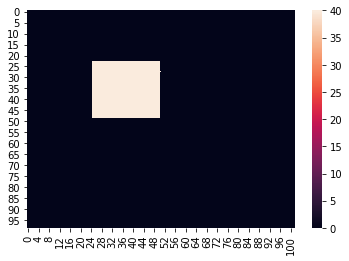

In [968]:
sns.heatmap(X0[1:101][1:101])

In [970]:
X0.shape

(102, 102)

In [923]:
a = np.zeros((4,102,102))

In [924]:
def actualizacion_as(a, X, d):
    for i in range(1,d + 1):
        for j in range(1,d + 1):
            a[0][i][j] =  D*(X[i][j] - X[i - 1][j])
            if a[0][i][j] < 0:
                a[0][i][j] = 0
            a[1][i][j] =  D*(X[i][j] - X[i + 1][j])
            if a[1][i][j] < 0:
                a[1][i][j] = 0
            a[2][i][j] =  D*(X[i][j] - X[i][j - 1])
            if a[2][i][j] < 0:
                a[2][i][j] = 0
            a[3][i][j] =  D*(X[i][j] - X[i][j + 1])
            if a[3][i][j] < 0:
                a[3][i][j] = 0
    return a

In [925]:
a = actualizacion_as(a,X0, 100)

In [926]:
a0 = fun_a0(a, 100)

In [927]:
P2 = np.zeros((4,102,102))
P3 = np.zeros((4))
P4 = np.zeros((4,102))
P5 = np.zeros((4,102))

In [930]:
P2, P3, P4, P5 = act_probs(a,a0,P2,P3,P4,P5,100)

In [931]:
P3

array([0.25, 0.25, 0.25, 0.25])

In [863]:
r1 = np.random.rand()
r2 = np.random.rand()
r3 = np.random.rand()
r4 = np.random.rand()

mu = fun_mu(P3,r2)
    
#Calculo del renglon

i = fun_i(P3,P4,r3,mu)

#Calculo de la columna

j = fun_j(P3,P5,r4,mu)

In [864]:
mu,i,j

(0, 25, 33)

#### Está mal actualizada $P_3(\mu|\tau)$ porque $a(\mu,i,j)$ no estaba operando bien

In [932]:
for i in range(20,56):
    print(P2[3][i][50])

0.0
0.0
0.0
0.0
0.0
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.009615384615384616
0.0
0.0
0.0
0.0
0.0


#### Is it $a(\mu,i,j)$ well calculated?

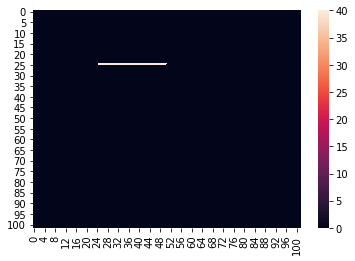

In [933]:
sns.heatmap(a[0][:][:])

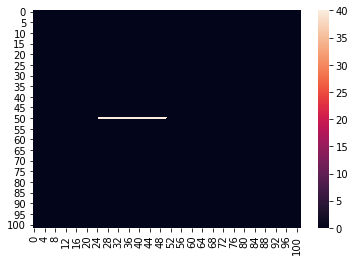

In [934]:
sns.heatmap(a[1][:][:])

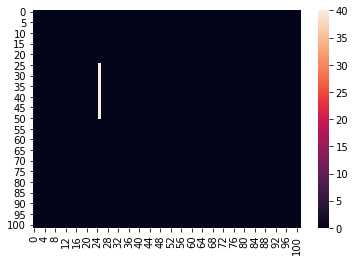

In [935]:
sns.heatmap(a[2][:][:])

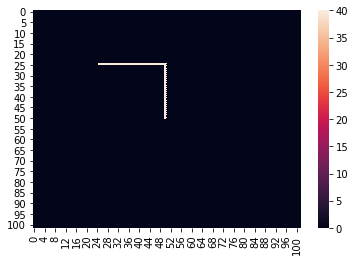

In [443]:
sns.heatmap(a[3][:][:])

#### Is not!!!

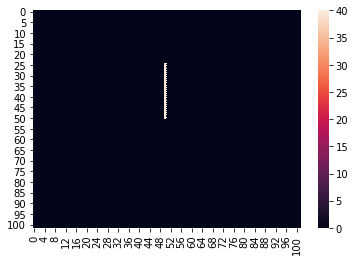

In [936]:
sns.heatmap(a[3][:][:])

In [937]:
P2[0][25][26]

0.009615384615384616

#### $P_2(\mu | \tau)$ is well calculated...is it!?

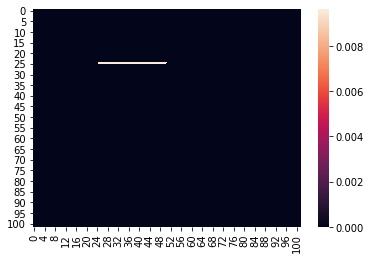

In [938]:
sns.heatmap(P2[0][:][:])

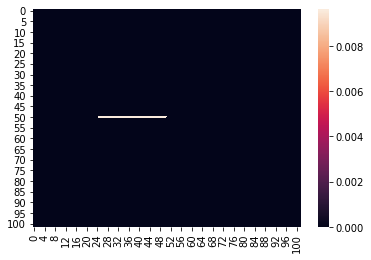

In [939]:
sns.heatmap(P2[1][:][:])

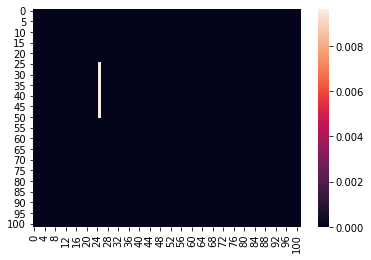

In [940]:
sns.heatmap(P2[2][:][:])

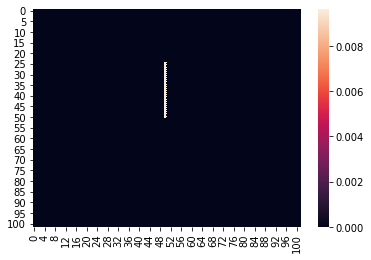

In [941]:
sns.heatmap(P2[3][:][:])

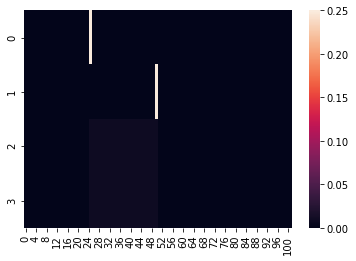

In [942]:
sns.heatmap(P4)

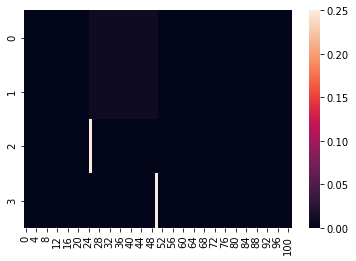

In [943]:
sns.heatmap(P5)

In [794]:
import time

In [791]:
X0 = X

## Simulación

In [1012]:
def nombre(s):
    diferencia = 4 - len(str(s))
    ceros = '' 
    for i in range(diferencia):
        ceros = ceros + '0'
    variable = ceros + str(s)
    return variable

In [1008]:
!pwd

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [1009]:
%mkdir "Gillespie_Sim_dif_00"

In [1010]:
%cd Gillespie_Sim_dif_00/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Gillespie_Sim_dif_00


In [1036]:
%cd ..

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [1037]:
%mkdir Gillespie_Sim_dif_01

In [1038]:
%cd Gillespie_Sim_dif_01/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Gillespie_Sim_dif_01


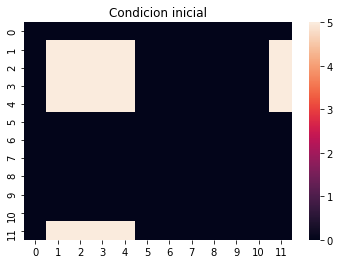

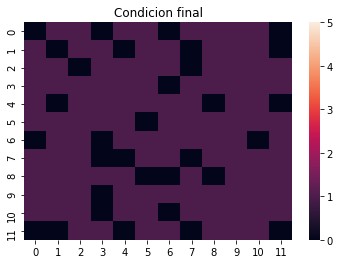

- 32.814434385299684 minutos de simulación -


In [1050]:
start_time = time.time()

N_pasos = 6000


d = 10

# Creamos una condicion inicial; una distribucion de particulas inicial

X0 = np.zeros((d + 2, d + 2))

for i in range(1,5):
    for j in range(1,5):
        X0[i][j] = 5


# Replicamos las condiciones iniciales en el borde

X0 = func_act_CC(X0, d)

# Visualizamos la conddicion inicial

sns.heatmap(X0, vmin=0, vmax=5)
plt.title("Condicion inicial")
plt.savefig('Gillespie_Dif_{}.png'.format(nombre(0)))
plt.show()

# Iniciamos los vetores para las propensiones y probabilidades condicionadas

a = np.zeros((4,d + 2,d + 2))
P2 = np.zeros((4,d + 2,d + 2))
P3 = np.zeros((4))
P4 = np.zeros((d + 2))
#P5 = np.zeros((4,102))

# Iniciamos el tiempo

t = 0

# Calculamos las propensiones

a = actualizacion_as(a,X0, d)

# Lista para registrar los momentos de actualizacion

tiempos = [0]

# Calculo de las probabilidades iniciales

P2, P3 = act_probs(a,a0,P2,P3, d)


# Bucle Principal Monte Carlo

for i in range(0,N_pasos):
    t, X0, a, P2, P3 = paso_montecarlo(X0, a, t, P2, P3, d)
    tiempos.append(t)
    fig = plt.figure()
    sns.heatmap(X0, vmin=0, vmax=5)
    fig.savefig('Gillespie_Dif_{}.png'.format(nombre(i+1)))
    plt.close()
    #fig.show()
    
sns.heatmap(X0, vmin=0, vmax=5)
plt.title("Condicion final")
plt.show()

tiempo_Sim = (time.time() - start_time)/60.

print("- %s minutos de simulación -" % (tiempo_Sim))

In [1019]:
102 % 100

2

In [1046]:
!mencoder "mf://*.png" -o Ani_Gill_Dif_03.mov -ovc lavc -lavcopts vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:dia=2:o=mpv_flags=+mv0:last_pred=3 -fps 20;
                                        


MEncoder 1.3.0-4.2.1 (C) 2000-2016 MPlayer Team
224 audio & 451 video codecs

success: format: 16  data: 0x0 - 0x0
MF file format detected.
[mf] search expr: *.png
[mf] number of files: 601 (4808)
[demux_mf] file type was not set! trying 'type=png'...
VIDEO:  [MPNG]  0x0  24bpp  25.000 fps    0.0 kbps ( 0.0 kbyte/s)
[V] filefmt:16  fourcc:0x474E504D  size:0x0  fps:25.000  ftime:=0.0400
Input fps will be interpreted as 20.000 instead.
libavcodec version 57.24.102 (internal)
Opening video filter: [expand osd=1]
Expand: -1 x -1, -1 ; -1, osd: 1, aspect: 0.000000, round: 1
Opening video decoder: [ffmpeg] FFmpeg's libavcodec codec family
Selected video codec: [ffpng] vfm: ffmpeg (FFmpeg PNG)
Could not find matching colorspace - retrying with -vf scale...
Opening video filter: [scale]
Movie-Aspect is undefined - no prescaling applied.
[swscaler @ 0x101c51410]bicubic scaler, from rgba to yuv420p using MMXEXT
videocodec: libavcodec (432x288 fourcc=3234504d [MP42])
[VE_LAVC] High quality encodi

Pos:   2.2s     45f ( 7%)  0.00fps Trem:   0min   0mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   2.3s     46f ( 7%)  0.00fps Trem:   0min   0mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   2.4s     47f ( 7%)  0.00fps Trem:   0min   0mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   2.4s     48f ( 8%)  0.00fps Trem:   0min   0mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   2.5s     49f ( 8%)  0.00fps Trem:   0min   0mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   2.5s     50f ( 8%)  0.00fps Trem:   0min   0mb  A-V:0.000 [173:0]
[msmpeg

Pos:   4.6s     92f (15%)  0.00fps Trem:   0min   0mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   4.7s     93f (15%)  0.00fps Trem:   0min   0mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   4.7s     94f (15%)  0.00fps Trem:   0min   0mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   4.8s     95f (15%)  0.00fps Trem:   0min   0mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   4.8s     96f (16%)  0.00fps Trem:   0min   0mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   4.8s     97f (16%)  0.00fps Trem:   0min   0mb  A-V:0.000 [159:0]
[msmpeg

Pos:   7.0s    140f (23%) 130.84fps Trem:   0min   0mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   7.0s    141f (23%) 128.77fps Trem:   0min   0mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   7.1s    142f (23%) 128.51fps Trem:   0min   0mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   7.2s    143f (23%) 128.48fps Trem:   0min   0mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   7.2s    144f (24%) 128.11fps Trem:   0min   0mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   7.2s    145f (24%) 127.30fps Trem:   0min   0mb  A-V:0.000 [167:0]
[

Pos:   9.3s    186f (31%) 129.89fps Trem:   0min   0mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   9.3s    187f (31%) 130.04fps Trem:   0min   0mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   9.4s    188f (31%) 130.19fps Trem:   0min   0mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   9.4s    189f (31%) 130.34fps Trem:   0min   0mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   9.5s    190f (31%) 130.58fps Trem:   0min   0mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:   9.6s    191f (31%) 130.73fps Trem:   0min   0mb  A-V:0.000 [161:0]
[

Pos:  11.8s    237f (39%) 135.58fps Trem:   0min   0mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  11.9s    238f (39%) 135.77fps Trem:   0min   0mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  11.9s    239f (39%) 135.87fps Trem:   0min   0mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  12.0s    240f (40%) 135.98fps Trem:   0min   0mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  12.1s    241f (40%) 136.16fps Trem:   0min   0mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  12.1s    242f (40%) 136.34fps Trem:   0min   0mb  A-V:0.000 [163:0]
[

Pos:  14.2s    284f (47%) 141.50fps Trem:   0min   0mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  14.2s    285f (47%) 141.51fps Trem:   0min   0mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  14.3s    286f (47%) 141.58fps Trem:   0min   0mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  14.3s    287f (47%) 141.66fps Trem:   0min   0mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  14.4s    288f (48%) 141.80fps Trem:   0min   0mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  14.4s    289f (48%) 141.88fps Trem:   0min   0mb  A-V:0.000 [170:0]
[

Pos:  16.8s    335f (55%) 144.09fps Trem:   0min   0mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  16.8s    336f (56%) 144.08fps Trem:   0min   0mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  16.9s    337f (56%) 144.08fps Trem:   0min   0mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  16.9s    338f (56%) 144.08fps Trem:   0min   0mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  16.9s    339f (56%) 144.01fps Trem:   0min   0mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  17.0s    340f (56%) 144.01fps Trem:   0min   0mb  A-V:0.000 [167:0]
[

Pos:  19.3s    386f (64%) 138.45fps Trem:   0min   0mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  19.4s    387f (64%) 138.26fps Trem:   0min   0mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  19.4s    388f (64%) 138.32fps Trem:   0min   0mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  19.4s    389f (64%) 138.29fps Trem:   0min   0mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  19.5s    390f (65%) 138.35fps Trem:   0min   0mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  19.6s    391f (65%) 138.46fps Trem:   0min   0mb  A-V:0.000 [162:0]
[

Pos:  21.9s    438f (73%) 141.15fps Trem:   0min   0mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  21.9s    439f (73%) 141.20fps Trem:   0min   0mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  22.0s    440f (73%) 141.25fps Trem:   0min   0mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  22.1s    441f (73%) 141.35fps Trem:   0min   0mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  22.1s    442f (73%) 141.44fps Trem:   0min   0mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  22.1s    443f (73%) 141.40fps Trem:   0min   0mb  A-V:0.000 [167:0]
[

Pos:  24.1s    483f (80%) 143.71fps Trem:   0min   0mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  24.2s    484f (80%) 143.75fps Trem:   0min   0mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  24.2s    485f (80%) 143.83fps Trem:   0min   0mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  24.3s    486f (81%) 143.87fps Trem:   0min   0mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  24.4s    487f (81%) 143.96fps Trem:   0min   0mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  24.4s    488f (81%) 144.04fps Trem:   0min   0mb  A-V:0.000 [164:0]
[

Pos:  26.4s    528f (88%) 145.82fps Trem:   0min   0mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  26.4s    529f (88%) 145.73fps Trem:   0min   0mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  26.5s    530f (88%) 145.72fps Trem:   0min   0mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  26.6s    531f (88%) 145.80fps Trem:   0min   0mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  26.6s    532f (88%) 145.79fps Trem:   0min   0mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  26.6s    533f (88%) 145.87fps Trem:   0min   0mb  A-V:0.000 [166:0]
[

Pos:  28.9s    577f (96%) 146.78fps Trem:   0min   0mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  28.9s    578f (96%) 146.74fps Trem:   0min   0mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  28.9s    579f (96%) 146.69fps Trem:   0min   0mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  29.0s    580f (96%) 146.58fps Trem:   0min   0mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  29.1s    581f (96%) 146.57fps Trem:   0min   0mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x101c37fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x101c37fe0]AVFrame.width or height is not set
Pos:  29.1s    582f (97%) 146.56fps Trem:   0min   0mb  A-V:0.000 [161:0]
[

### Una reverenda mamada que haya cantidades negativas!!!!

Observaciones:
 - Está eligiendo regiones donde no hay partículas
 - Sin embargo, esto no tiene que ver con el cálculo de las $a(\mu,i,j)$, puesto que éstas son nulas en estos puntos
 - Todo indica que se debe a cómo se elige el punto donde se actualizan o el proceso, está eligiendo procesos de probabilidad nula!
 - Tiene que ser con la función que regresa las $mu$, $i$'s y $j$'s!!!
 - Otra pendajada inadmisible es que se pueden acumular particulas en una celda que superen la mayor concentracion máxima inicial!!!

In [902]:
tiempos

[0,
 0.022782939057878905,
 0.02610734412882857,
 0.048790656058410486,
 0.05771995365733049,
 0.05995416170285268,
 0.07688927362413511,
 0.09792596082899703,
 0.10064685583037497,
 0.10404976320464035,
 0.11157473891397447,
 0.11502195889833153,
 0.1197911972663537,
 0.12623550920730012,
 0.1297562360642434,
 0.13139343479445117,
 0.134924822172062,
 0.135850289238767,
 0.1359292925957475,
 0.1390414233509816,
 0.14343814691700968,
 0.14419596259873646,
 0.14493522209833276,
 0.14637190048680093,
 0.15072595141180445,
 0.1555651467744636,
 0.15729701225676557,
 0.1577887476805447,
 0.1585282839226886,
 0.1671757133157456,
 0.17313668989253111,
 0.1788557922846567,
 0.18104822388124395,
 0.18634442204578164,
 0.1933080349416896,
 0.19494516780948318,
 0.19573634084666922,
 0.19602582663045978,
 0.19953661279231316,
 0.21106746884781957,
 0.21500883291801848,
 0.21805031390903748,
 0.22207368125837582,
 0.24101787380098796,
 0.2412863888742947,
 0.24533605437751957,
 0.2544760208826429

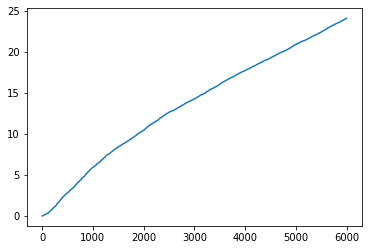

In [1094]:
plt.plot(tiempos)

### Pruebas

In [1055]:
XT = X0[1:d+1, 1:d+1] 

In [1056]:
X0.shape

(12, 12)

In [1057]:
XT.shape

(10, 10)

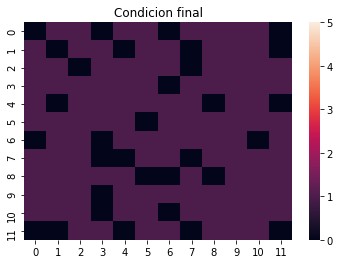

In [1058]:
sns.heatmap(X0, vmin=0, vmax=5)
plt.title("Condicion final")
plt.show()

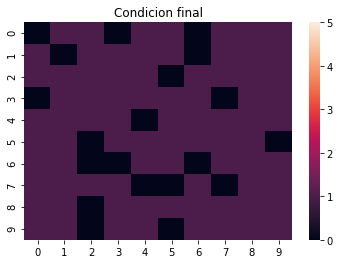

In [1059]:
sns.heatmap(XT, vmin=0, vmax=5)
plt.title("Condicion final")
plt.show()

### Funciones de distribución inicial

In [1062]:
def dist_circ(centro, radio, n, d):
    X0 = np.zeros((d + 2, d + 2))
    for i in range(1,d + 1):
        for j in range(1,d + 1):
            rs = (i - centro[0])**2 + (j - centro[1])**2
            if rs < radio**2:
                X0[i,j] = n
    return X0

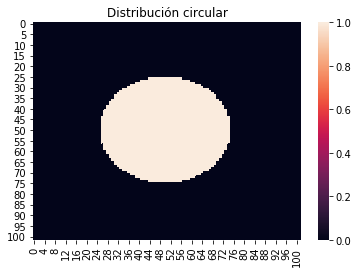

In [1086]:
sns.heatmap(dist_circ((50,50), 25, 1, 100), vmin=0, vmax=1)
plt.title("Distribución circular")
plt.show()

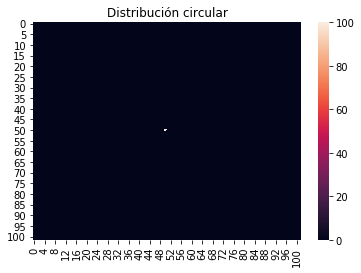

In [1071]:
sns.heatmap(dist_circ((50,50), 1, 100, 100), vmin=0, vmax=100)
plt.title("Distribución circular")
plt.show()

In [1072]:
!pwd

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Gillespie_Sim_dif_01


In [1073]:
%cd ..

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [1074]:
%mkdir Gillespie_for_Green

In [1075]:
%cd Gillespie_for_Green/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Gillespie_for_Green


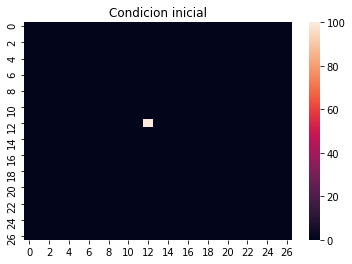

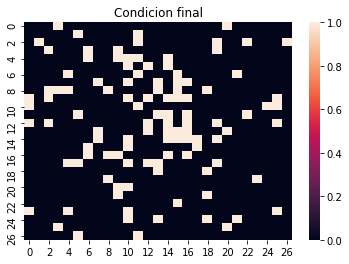

- 53.61308699448903 minutos de simulación -


In [1092]:
start_time = time.time()

N_pasos = 6000


d = 25

# Creamos una condicion inicial; una distribucion de particulas inicial

X0 = dist_circ((12,12), 1, 100, d)



# Replicamos las condiciones iniciales en el borde

X0 = func_act_CC(X0, d)

# Visualizamos la conddicion inicial

sns.heatmap(X0, vmin=0, vmax=100)
plt.title("Condicion inicial")
plt.savefig('Gillespie_Dif_{}.png'.format(nombre(0)))
plt.show()

# Iniciamos los vetores para las propensiones y probabilidades condicionadas

a = np.zeros((4,d + 2,d + 2))
P2 = np.zeros((4,d + 2,d + 2))
P3 = np.zeros((4))
P4 = np.zeros((d + 2))
#P5 = np.zeros((4,102))

# Iniciamos el tiempo

t = 0

# Calculamos las propensiones

a = actualizacion_as(a,X0, d)

# Lista para registrar los momentos de actualizacion

tiempos = [0]

# Calculo de las probabilidades iniciales

P2, P3 = act_probs(a,a0,P2,P3, d)


# Bucle Principal Monte Carlo

for i in range(0,N_pasos):
    t, X0, a, P2, P3 = paso_montecarlo(X0, a, t, P2, P3, d)
    tiempos.append(t)
    fig = plt.figure()
    sns.heatmap(X0)
    fig.savefig('Gillespie_Dif_{}.png'.format(nombre(i+1)))
    plt.close()
    #fig.show()
    
sns.heatmap(X0)
plt.title("Condicion final")
plt.show()

tiempo_Sim = (time.time() - start_time)/60.

print("- %s minutos de simulación -" % (tiempo_Sim))

In [1081]:
X0 = dist_circ((50,50), 25, 100, 100)

In [1079]:
X0 = func_act_CC(X0, d)

In [1100]:
!mencoder "mf://*.png" -o Ani_Gill_Dif_FAST_05.mov -ovc lavc -lavcopts vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:dia=2:o=mpv_flags=+mv0:last_pred=3 -fps 35;
                                        


MEncoder 1.3.0-4.2.1 (C) 2000-2016 MPlayer Team
224 audio & 451 video codecs

success: format: 16  data: 0x0 - 0x0
MF file format detected.
[mf] search expr: *.png
[mf] number of files: 6001 (48008)
[demux_mf] file type was not set! trying 'type=png'...
VIDEO:  [MPNG]  0x0  24bpp  25.000 fps    0.0 kbps ( 0.0 kbyte/s)
[V] filefmt:16  fourcc:0x474E504D  size:0x0  fps:25.000  ftime:=0.0400
Input fps will be interpreted as 35.000 instead.
libavcodec version 57.24.102 (internal)
Opening video filter: [expand osd=1]
Expand: -1 x -1, -1 ; -1, osd: 1, aspect: 0.000000, round: 1
Opening video decoder: [ffmpeg] FFmpeg's libavcodec codec family
Selected video codec: [ffpng] vfm: ffmpeg (FFmpeg PNG)
Could not find matching colorspace - retrying with -vf scale...
Opening video filter: [scale]
Movie-Aspect is undefined - no prescaling applied.
[swscaler @ 0x104398410]bicubic scaler, from rgba to yuv420p using MMXEXT
videocodec: libavcodec (432x288 fourcc=3234504d [MP42])
[VE_LAVC] High quality enco

Pos:   1.2s     41f ( 0%)  0.00fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   1.2s     42f ( 0%)  0.00fps Trem:   0min   3mb  A-V:0.000 [150:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   1.2s     43f ( 0%)  0.00fps Trem:   0min   3mb  A-V:0.000 [147:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   1.3s     44f ( 0%)  0.00fps Trem:   0min   3mb  A-V:0.000 [147:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   1.3s     45f ( 0%)  0.00fps Trem:   0min   3mb  A-V:0.000 [147:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   1.3s     46f ( 0%)  0.00fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg

Pos:   2.5s     86f ( 1%)  0.00fps Trem:   0min   2mb  A-V:0.000 [108:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   2.5s     87f ( 1%)  0.00fps Trem:   0min   2mb  A-V:0.000 [108:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   2.5s     88f ( 1%)  0.00fps Trem:   0min   2mb  A-V:0.000 [108:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   2.5s     89f ( 1%)  0.00fps Trem:   0min   2mb  A-V:0.000 [108:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   2.6s     90f ( 1%)  0.00fps Trem:   0min   2mb  A-V:0.000 [107:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   2.6s     91f ( 1%)  0.00fps Trem:   0min   2mb  A-V:0.000 [109:0]
[msmpeg

Pos:   3.8s    133f ( 2%) 119.71fps Trem:   0min   3mb  A-V:0.000 [141:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   3.8s    134f ( 2%) 119.54fps Trem:   0min   3mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   3.9s    135f ( 2%) 119.57fps Trem:   0min   3mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   3.9s    136f ( 2%) 118.47fps Trem:   0min   3mb  A-V:0.000 [141:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   3.9s    137f ( 2%) 118.72fps Trem:   0min   3mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   3.9s    138f ( 2%) 116.26fps Trem:   0min   3mb  A-V:0.000 [139:0]
[

Pos:   5.1s    178f ( 2%) 120.68fps Trem:   0min   3mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   5.1s    179f ( 2%) 120.70fps Trem:   0min   3mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   5.1s    180f ( 2%) 120.89fps Trem:   0min   3mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   5.2s    181f ( 3%) 120.91fps Trem:   0min   3mb  A-V:0.000 [138:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   5.2s    182f ( 3%) 121.01fps Trem:   0min   3mb  A-V:0.000 [138:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   5.2s    183f ( 3%) 121.11fps Trem:   0min   3mb  A-V:0.000 [140:0]
[

Pos:   6.5s    226f ( 3%) 121.51fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   6.5s    227f ( 3%) 121.33fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   6.5s    228f ( 3%) 115.79fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   6.5s    229f ( 3%) 115.89fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   6.6s    230f ( 3%) 115.99fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   6.6s    231f ( 3%) 116.02fps Trem:   0min   2mb  A-V:0.000 [125:0]
[

Pos:   7.8s    273f ( 4%) 114.85fps Trem:   0min   2mb  A-V:0.000 [136:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   7.8s    274f ( 4%) 110.31fps Trem:   0min   2mb  A-V:0.000 [136:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   7.9s    275f ( 4%) 109.13fps Trem:   0min   2mb  A-V:0.000 [136:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   7.9s    276f ( 4%) 109.09fps Trem:   0min   2mb  A-V:0.000 [135:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   7.9s    277f ( 4%) 105.97fps Trem:   0min   2mb  A-V:0.000 [135:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   7.9s    278f ( 4%) 105.82fps Trem:   0min   2mb  A-V:0.000 [135:0]
[

Pos:   9.1s    317f ( 5%) 106.99fps Trem:   0min   2mb  A-V:0.000 [128:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   9.1s    318f ( 5%) 106.82fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   9.1s    319f ( 5%) 106.94fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   9.1s    320f ( 5%) 106.95fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   9.2s    321f ( 5%) 107.07fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:   9.2s    322f ( 5%) 107.15fps Trem:   0min   2mb  A-V:0.000 [127:0]
[

Pos:  10.6s    370f ( 6%) 106.54fps Trem:   0min   2mb  A-V:0.000 [123:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  10.6s    371f ( 6%) 106.61fps Trem:   0min   2mb  A-V:0.000 [122:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  10.6s    372f ( 6%) 106.74fps Trem:   0min   2mb  A-V:0.000 [122:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  10.7s    373f ( 6%) 106.88fps Trem:   0min   2mb  A-V:0.000 [122:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  10.7s    374f ( 6%) 106.98fps Trem:   0min   2mb  A-V:0.000 [122:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  10.7s    375f ( 6%) 107.11fps Trem:   0min   2mb  A-V:0.000 [122:0]
[

Pos:  11.9s    415f ( 6%) 105.52fps Trem:   0min   2mb  A-V:0.000 [131:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  11.9s    416f ( 6%) 105.53fps Trem:   0min   2mb  A-V:0.000 [130:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  11.9s    417f ( 6%) 105.49fps Trem:   0min   2mb  A-V:0.000 [130:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  11.9s    418f ( 6%) 105.45fps Trem:   0min   2mb  A-V:0.000 [130:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  12.0s    419f ( 6%) 105.33fps Trem:   0min   2mb  A-V:0.000 [130:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  12.0s    420f ( 6%) 105.40fps Trem:   0min   2mb  A-V:0.000 [130:0]
[

Pos:  13.1s    459f ( 7%) 103.19fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  13.1s    460f ( 7%) 103.07fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  13.2s    461f ( 7%) 103.13fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  13.2s    462f ( 7%) 103.10fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  13.2s    463f ( 7%) 103.07fps Trem:   0min   2mb  A-V:0.000 [125:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  13.3s    464f ( 7%) 102.91fps Trem:   0min   2mb  A-V:0.000 [125:0]
[

Pos:  14.5s    506f ( 8%) 103.08fps Trem:   0min   2mb  A-V:0.000 [122:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  14.5s    507f ( 8%) 102.97fps Trem:   0min   2mb  A-V:0.000 [122:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  14.5s    508f ( 8%) 102.88fps Trem:   0min   2mb  A-V:0.000 [122:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  14.5s    509f ( 8%) 102.93fps Trem:   0min   2mb  A-V:0.000 [122:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  14.6s    510f ( 8%) 102.74fps Trem:   0min   2mb  A-V:0.000 [122:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  14.6s    511f ( 8%) 102.71fps Trem:   0min   2mb  A-V:0.000 [121:0]
[

Pos:  15.8s    553f ( 9%) 105.86fps Trem:   0min   2mb  A-V:0.000 [130:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  15.8s    554f ( 9%) 105.93fps Trem:   0min   2mb  A-V:0.000 [130:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  15.9s    555f ( 9%) 106.00fps Trem:   0min   2mb  A-V:0.000 [130:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  15.9s    556f ( 9%) 106.09fps Trem:   0min   2mb  A-V:0.000 [129:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  15.9s    557f ( 9%) 106.18fps Trem:   0min   2mb  A-V:0.000 [129:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  15.9s    558f ( 9%) 106.27fps Trem:   0min   2mb  A-V:0.000 [129:0]
[

Pos:  17.2s    603f (10%) 109.98fps Trem:   0min   2mb  A-V:0.000 [127:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  17.3s    604f (10%) 110.06fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  17.3s    605f (10%) 110.14fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  17.3s    606f (10%) 110.22fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  17.3s    607f (10%) 110.28fps Trem:   0min   2mb  A-V:0.000 [126:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  17.4s    608f (10%) 110.36fps Trem:   0min   2mb  A-V:0.000 [126:0]
[

Pos:  18.6s    651f (10%) 113.49fps Trem:   0min   2mb  A-V:0.000 [124:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  18.6s    652f (10%) 113.55fps Trem:   0min   2mb  A-V:0.000 [124:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  18.7s    653f (10%) 113.62fps Trem:   0min   2mb  A-V:0.000 [124:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  18.7s    654f (10%) 113.70fps Trem:   0min   2mb  A-V:0.000 [124:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  18.7s    655f (10%) 113.75fps Trem:   0min   2mb  A-V:0.000 [124:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  18.7s    656f (10%) 113.83fps Trem:   0min   2mb  A-V:0.000 [124:0]
[

Pos:  20.0s    699f (11%) 116.60fps Trem:   0min   2mb  A-V:0.000 [133:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  20.0s    700f (11%) 116.63fps Trem:   0min   2mb  A-V:0.000 [133:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  20.0s    701f (11%) 116.68fps Trem:   0min   2mb  A-V:0.000 [133:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  20.1s    702f (11%) 116.75fps Trem:   0min   2mb  A-V:0.000 [133:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  20.1s    703f (11%) 116.82fps Trem:   0min   2mb  A-V:0.000 [133:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  20.1s    704f (11%) 116.87fps Trem:   0min   2mb  A-V:0.000 [133:0]
[

Pos:  21.3s    744f (12%) 118.94fps Trem:   0min   2mb  A-V:0.000 [131:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  21.3s    745f (12%) 118.99fps Trem:   0min   2mb  A-V:0.000 [131:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  21.3s    746f (12%) 119.06fps Trem:   0min   2mb  A-V:0.000 [131:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  21.3s    747f (12%) 119.10fps Trem:   0min   2mb  A-V:0.000 [131:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  21.4s    748f (12%) 119.17fps Trem:   0min   2mb  A-V:0.000 [131:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  21.4s    749f (12%) 119.23fps Trem:   0min   2mb  A-V:0.000 [131:0]
[

Pos:  22.7s    794f (13%) 121.84fps Trem:   0min   2mb  A-V:0.000 [138:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  22.7s    795f (13%) 121.84fps Trem:   0min   2mb  A-V:0.000 [138:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  22.7s    796f (13%) 121.90fps Trem:   0min   2mb  A-V:0.000 [138:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  22.8s    797f (13%) 121.96fps Trem:   0min   2mb  A-V:0.000 [138:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  22.8s    798f (13%) 122.02fps Trem:   0min   2mb  A-V:0.000 [138:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  22.8s    799f (13%) 122.08fps Trem:   0min   2mb  A-V:0.000 [138:0]
[

Pos:  24.1s    843f (14%) 124.52fps Trem:   0min   2mb  A-V:0.000 [137:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  24.1s    844f (14%) 124.58fps Trem:   0min   2mb  A-V:0.000 [136:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  24.1s    845f (14%) 124.63fps Trem:   0min   2mb  A-V:0.000 [136:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  24.2s    846f (14%) 124.69fps Trem:   0min   2mb  A-V:0.000 [136:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  24.2s    847f (14%) 124.74fps Trem:   0min   2mb  A-V:0.000 [136:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  24.2s    848f (14%) 124.80fps Trem:   0min   2mb  A-V:0.000 [136:0]
[

Pos:  25.5s    893f (14%) 127.01fps Trem:   0min   2mb  A-V:0.000 [135:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  25.5s    894f (14%) 127.06fps Trem:   0min   2mb  A-V:0.000 [135:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  25.6s    895f (14%) 127.11fps Trem:   0min   2mb  A-V:0.000 [135:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  25.6s    896f (14%) 127.16fps Trem:   0min   2mb  A-V:0.000 [135:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  25.6s    897f (14%) 127.22fps Trem:   0min   2mb  A-V:0.000 [135:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  25.7s    898f (14%) 127.27fps Trem:   0min   2mb  A-V:0.000 [135:0]
[

Pos:  26.9s    943f (15%) 129.44fps Trem:   0min   2mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  27.0s    944f (15%) 129.47fps Trem:   0min   2mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  27.0s    945f (15%) 129.52fps Trem:   0min   2mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  27.0s    946f (15%) 129.59fps Trem:   0min   2mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  27.1s    947f (15%) 129.64fps Trem:   0min   2mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  27.1s    948f (15%) 129.69fps Trem:   0min   2mb  A-V:0.000 [140:0]
[

Pos:  28.4s    994f (16%) 131.78fps Trem:   0min   2mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  28.4s    995f (16%) 131.81fps Trem:   0min   2mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  28.5s    996f (16%) 131.85fps Trem:   0min   2mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  28.5s    997f (16%) 131.91fps Trem:   0min   2mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  28.5s    998f (16%) 131.96fps Trem:   0min   2mb  A-V:0.000 [139:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  28.5s    999f (16%) 132.00fps Trem:   0min   2mb  A-V:0.000 [139:0]
[

Pos:  29.9s   1045f (17%) 133.94fps Trem:   0min   2mb  A-V:0.000 [137:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  29.9s   1046f (17%) 133.98fps Trem:   0min   2mb  A-V:0.000 [137:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  29.9s   1047f (17%) 134.02fps Trem:   0min   2mb  A-V:0.000 [137:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  29.9s   1048f (17%) 134.07fps Trem:   0min   2mb  A-V:0.000 [137:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  30.0s   1049f (17%) 134.11fps Trem:   0min   2mb  A-V:0.000 [137:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  30.0s   1050f (17%) 134.15fps Trem:   0min   2mb  A-V:0.000 [137:0]
[

Pos:  31.2s   1092f (18%) 132.25fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  31.2s   1093f (18%) 132.23fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  31.3s   1094f (18%) 132.27fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  31.3s   1095f (18%) 132.29fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  31.3s   1096f (18%) 132.34fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  31.3s   1097f (18%) 132.38fps Trem:   0min   2mb  A-V:0.000 [142:0]
[

Pos:  32.6s   1141f (19%) 133.90fps Trem:   0min   2mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  32.6s   1142f (19%) 133.94fps Trem:   0min   2mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  32.7s   1143f (19%) 133.98fps Trem:   0min   2mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  32.7s   1144f (19%) 134.02fps Trem:   0min   2mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  32.7s   1145f (19%) 134.06fps Trem:   0min   2mb  A-V:0.000 [140:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  32.7s   1146f (19%) 134.10fps Trem:   0min   2mb  A-V:0.000 [140:0]
[

Pos:  34.0s   1190f (19%) 135.60fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  34.0s   1191f (19%) 135.63fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  34.1s   1192f (19%) 135.65fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  34.1s   1193f (19%) 135.71fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  34.1s   1194f (19%) 135.74fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  34.1s   1195f (19%) 135.78fps Trem:   0min   3mb  A-V:0.000 [144:0]
[

Pos:  35.3s   1237f (20%) 136.90fps Trem:   0min   2mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  35.4s   1238f (20%) 136.84fps Trem:   0min   2mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  35.4s   1239f (20%) 136.86fps Trem:   0min   2mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  35.4s   1240f (20%) 136.90fps Trem:   0min   2mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  35.5s   1241f (20%) 136.85fps Trem:   0min   2mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  35.5s   1242f (20%) 136.89fps Trem:   0min   2mb  A-V:0.000 [142:0]
[

Pos:  36.8s   1287f (21%) 137.74fps Trem:   0min   2mb  A-V:0.000 [141:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  36.8s   1288f (21%) 137.77fps Trem:   0min   2mb  A-V:0.000 [141:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  36.8s   1289f (21%) 137.79fps Trem:   0min   2mb  A-V:0.000 [141:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  36.9s   1290f (21%) 137.79fps Trem:   0min   2mb  A-V:0.000 [141:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  36.9s   1291f (21%) 137.81fps Trem:   0min   2mb  A-V:0.000 [141:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  36.9s   1292f (21%) 137.77fps Trem:   0min   2mb  A-V:0.000 [141:0]
[

Pos:  38.3s   1339f (22%) 138.67fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  38.3s   1340f (22%) 138.62fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  38.3s   1341f (22%) 138.60fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  38.3s   1342f (22%) 137.87fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  38.4s   1343f (22%) 137.48fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  38.4s   1344f (22%) 137.37fps Trem:   0min   3mb  A-V:0.000 [144:0]
[

Pos:  39.7s   1388f (23%) 133.59fps Trem:   0min   3mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  39.7s   1389f (23%) 133.60fps Trem:   0min   2mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  39.7s   1390f (23%) 133.60fps Trem:   0min   2mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  39.7s   1391f (23%) 133.63fps Trem:   0min   2mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  39.8s   1392f (23%) 133.67fps Trem:   0min   2mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  39.8s   1393f (23%) 133.67fps Trem:   0min   2mb  A-V:0.000 [143:0]
[

Pos:  40.9s   1432f (23%) 134.43fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  40.9s   1433f (23%) 134.44fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  41.0s   1434f (23%) 134.46fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  41.0s   1435f (23%) 134.48fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  41.0s   1436f (23%) 134.51fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  41.1s   1437f (23%) 134.53fps Trem:   0min   2mb  A-V:0.000 [142:0]
[

Pos:  42.2s   1476f (24%) 135.33fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  42.2s   1477f (24%) 135.33fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  42.2s   1478f (24%) 135.35fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  42.3s   1479f (24%) 135.32fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  42.3s   1480f (24%) 135.30fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  42.3s   1481f (24%) 135.31fps Trem:   0min   3mb  A-V:0.000 [145:0]
[

Pos:  43.6s   1527f (25%) 136.08fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  43.7s   1528f (25%) 136.09fps Trem:   0min   3mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  43.7s   1529f (25%) 136.09fps Trem:   0min   3mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  43.7s   1530f (25%) 136.11fps Trem:   0min   3mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  43.7s   1531f (25%) 136.14fps Trem:   0min   3mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  43.8s   1532f (25%) 136.15fps Trem:   0min   3mb  A-V:0.000 [143:0]
[

Pos:  45.0s   1576f (26%) 136.70fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  45.1s   1577f (26%) 136.70fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  45.1s   1578f (26%) 136.72fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  45.1s   1579f (26%) 136.73fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  45.1s   1580f (26%) 136.74fps Trem:   0min   2mb  A-V:0.000 [142:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  45.2s   1581f (26%) 136.76fps Trem:   0min   2mb  A-V:0.000 [142:0]
[

Pos:  46.3s   1622f (27%) 136.99fps Trem:   0min   3mb  A-V:0.000 [146:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  46.4s   1623f (27%) 137.00fps Trem:   0min   3mb  A-V:0.000 [146:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  46.4s   1624f (27%) 137.02fps Trem:   0min   3mb  A-V:0.000 [146:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  46.4s   1625f (27%) 137.03fps Trem:   0min   3mb  A-V:0.000 [146:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  46.5s   1626f (27%) 137.04fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  46.5s   1627f (27%) 137.06fps Trem:   0min   3mb  A-V:0.000 [145:0]
[

Pos:  47.6s   1667f (27%) 137.11fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  47.7s   1668f (27%) 137.10fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  47.7s   1669f (27%) 137.12fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  47.7s   1670f (27%) 137.12fps Trem:   0min   3mb  A-V:0.000 [144:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  47.7s   1671f (27%) 137.12fps Trem:   0min   3mb  A-V:0.000 [145:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  47.8s   1672f (27%) 137.13fps Trem:   0min   3mb  A-V:0.000 [144:0]
[

Pos:  49.0s   1715f (28%) 136.99fps Trem:   0min   3mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  49.0s   1716f (28%) 136.97fps Trem:   0min   2mb  A-V:0.000 [143:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  49.1s   1717f (28%) 136.95fps Trem:   0min   3mb  A-V:0.000 [147:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  49.1s   1718f (28%) 136.96fps Trem:   0min   3mb  A-V:0.000 [147:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  49.1s   1719f (28%) 136.95fps Trem:   0min   3mb  A-V:0.000 [147:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  49.1s   1720f (28%) 136.93fps Trem:   0min   3mb  A-V:0.000 [147:0]
[

Pos:  50.5s   1766f (29%) 137.64fps Trem:   0min   3mb  A-V:0.000 [149:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  50.5s   1767f (29%) 137.65fps Trem:   0min   3mb  A-V:0.000 [149:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  50.5s   1768f (29%) 137.67fps Trem:   0min   3mb  A-V:0.000 [149:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  50.5s   1769f (29%) 137.70fps Trem:   0min   3mb  A-V:0.000 [149:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  50.6s   1770f (29%) 137.71fps Trem:   0min   3mb  A-V:0.000 [149:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  50.6s   1771f (29%) 137.74fps Trem:   0min   3mb  A-V:0.000 [149:0]
[

Pos:  51.8s   1813f (30%) 137.94fps Trem:   0min   3mb  A-V:0.000 [148:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  51.8s   1814f (30%) 137.92fps Trem:   0min   3mb  A-V:0.000 [148:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  51.9s   1815f (30%) 137.93fps Trem:   0min   3mb  A-V:0.000 [148:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  51.9s   1816f (30%) 137.93fps Trem:   0min   3mb  A-V:0.000 [148:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  51.9s   1817f (30%) 137.92fps Trem:   0min   3mb  A-V:0.000 [148:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  51.9s   1818f (30%) 137.94fps Trem:   0min   3mb  A-V:0.000 [148:0]
[

Pos:  53.3s   1864f (31%) 138.56fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  53.3s   1865f (31%) 138.57fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  53.3s   1866f (31%) 138.57fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  53.3s   1867f (31%) 138.58fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  53.4s   1868f (31%) 138.60fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  53.4s   1869f (31%) 138.62fps Trem:   0min   3mb  A-V:0.000 [152:0]
[

Pos:  54.5s   1908f (31%) 139.18fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  54.5s   1909f (31%) 139.19fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  54.6s   1910f (31%) 139.20fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  54.6s   1911f (31%) 139.21fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  54.6s   1912f (31%) 139.24fps Trem:   0min   3mb  A-V:0.000 [152:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  54.7s   1913f (31%) 139.25fps Trem:   0min   3mb  A-V:0.000 [152:0]
[

Pos:  55.8s   1953f (32%) 139.80fps Trem:   0min   3mb  A-V:0.000 [151:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  55.8s   1954f (32%) 139.80fps Trem:   0min   3mb  A-V:0.000 [151:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  55.9s   1955f (32%) 139.81fps Trem:   0min   3mb  A-V:0.000 [151:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  55.9s   1956f (32%) 139.82fps Trem:   0min   3mb  A-V:0.000 [151:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  55.9s   1957f (32%) 139.83fps Trem:   0min   3mb  A-V:0.000 [151:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  55.9s   1958f (32%) 139.84fps Trem:   0min   3mb  A-V:0.000 [151:0]
[

Pos:  57.1s   1997f (33%) 139.82fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  57.1s   1998f (33%) 139.78fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  57.1s   1999f (33%) 139.79fps Trem:   0min   3mb  A-V:0.000 [154:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  57.1s   2000f (33%) 139.80fps Trem:   0min   3mb  A-V:0.000 [154:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  57.2s   2001f (33%) 139.81fps Trem:   0min   3mb  A-V:0.000 [154:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  57.2s   2002f (33%) 139.81fps Trem:   0min   3mb  A-V:0.000 [154:0]
[

Pos:  58.5s   2048f (34%) 140.28fps Trem:   0min   3mb  A-V:0.000 [154:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  58.5s   2049f (34%) 140.29fps Trem:   0min   3mb  A-V:0.000 [154:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  58.6s   2050f (34%) 140.31fps Trem:   0min   3mb  A-V:0.000 [154:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  58.6s   2051f (34%) 140.32fps Trem:   0min   3mb  A-V:0.000 [154:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  58.6s   2052f (34%) 140.33fps Trem:   0min   3mb  A-V:0.000 [154:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  58.7s   2053f (34%) 140.33fps Trem:   0min   3mb  A-V:0.000 [154:0]
[

Pos:  59.9s   2098f (34%) 140.77fps Trem:   0min   3mb  A-V:0.000 [153:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  60.0s   2099f (34%) 140.77fps Trem:   0min   3mb  A-V:0.000 [153:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  60.0s   2100f (34%) 140.72fps Trem:   0min   3mb  A-V:0.000 [153:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  60.0s   2101f (35%) 140.72fps Trem:   0min   3mb  A-V:0.000 [153:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  60.1s   2102f (35%) 140.71fps Trem:   0min   3mb  A-V:0.000 [153:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  60.1s   2103f (35%) 140.73fps Trem:   0min   3mb  A-V:0.000 [153:0]
[

Pos:  61.2s   2142f (35%) 140.81fps Trem:   0min   3mb  A-V:0.000 [156:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  61.2s   2143f (35%) 140.78fps Trem:   0min   3mb  A-V:0.000 [156:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  61.3s   2144f (35%) 140.78fps Trem:   0min   3mb  A-V:0.000 [156:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  61.3s   2145f (35%) 140.78fps Trem:   0min   3mb  A-V:0.000 [156:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  61.3s   2146f (35%) 140.79fps Trem:   0min   3mb  A-V:0.000 [156:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  61.3s   2147f (35%) 140.79fps Trem:   0min   3mb  A-V:0.000 [156:0]
[

Pos:  62.5s   2189f (36%) 140.99fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  62.6s   2190f (36%) 140.99fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  62.6s   2191f (36%) 140.99fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  62.6s   2192f (36%) 140.99fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  62.7s   2193f (36%) 140.99fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  62.7s   2194f (36%) 141.00fps Trem:   0min   3mb  A-V:0.000 [155:0]
[

Pos:  63.8s   2233f (37%) 141.47fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  63.8s   2234f (37%) 141.48fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  63.9s   2235f (37%) 141.49fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  63.9s   2236f (37%) 141.51fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  63.9s   2237f (37%) 141.52fps Trem:   0min   3mb  A-V:0.000 [155:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  63.9s   2238f (37%) 141.54fps Trem:   0min   3mb  A-V:0.000 [155:0]
[

Pos:  65.1s   2277f (37%) 141.91fps Trem:   0min   3mb  A-V:0.000 [158:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  65.1s   2278f (37%) 141.91fps Trem:   0min   3mb  A-V:0.000 [158:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  65.1s   2279f (37%) 141.92fps Trem:   0min   3mb  A-V:0.000 [158:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  65.1s   2280f (37%) 141.93fps Trem:   0min   3mb  A-V:0.000 [158:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  65.2s   2281f (38%) 141.94fps Trem:   0min   3mb  A-V:0.000 [158:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  65.2s   2282f (38%) 141.94fps Trem:   0min   3mb  A-V:0.000 [158:0]
[

Pos:  66.4s   2325f (38%) 141.67fps Trem:   0min   3mb  A-V:0.000 [158:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  66.5s   2326f (38%) 141.67fps Trem:   0min   3mb  A-V:0.000 [158:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  66.5s   2327f (38%) 141.68fps Trem:   0min   3mb  A-V:0.000 [158:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  66.5s   2328f (38%) 141.69fps Trem:   0min   3mb  A-V:0.000 [158:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  66.5s   2329f (38%) 141.69fps Trem:   0min   3mb  A-V:0.000 [158:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  66.6s   2330f (38%) 141.68fps Trem:   0min   3mb  A-V:0.000 [158:0]
[

Pos:  67.8s   2373f (39%) 141.87fps Trem:   0min   3mb  A-V:0.000 [157:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  67.8s   2374f (39%) 141.88fps Trem:   0min   3mb  A-V:0.000 [157:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  67.9s   2375f (39%) 141.89fps Trem:   0min   3mb  A-V:0.000 [157:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  67.9s   2376f (39%) 141.89fps Trem:   0min   3mb  A-V:0.000 [157:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  67.9s   2377f (39%) 141.90fps Trem:   0min   3mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  67.9s   2378f (39%) 141.90fps Trem:   0min   3mb  A-V:0.000 [160:0]
[

Pos:  69.2s   2423f (40%) 142.23fps Trem:   0min   3mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  69.3s   2424f (40%) 142.24fps Trem:   0min   3mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  69.3s   2425f (40%) 142.24fps Trem:   0min   3mb  A-V:0.000 [160:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  69.3s   2426f (40%) 142.24fps Trem:   0min   3mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  69.3s   2427f (40%) 142.25fps Trem:   0min   3mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  69.4s   2428f (40%) 142.25fps Trem:   0min   3mb  A-V:0.000 [159:0]
[

Pos:  70.5s   2467f (41%) 142.23fps Trem:   0min   3mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  70.5s   2468f (41%) 142.22fps Trem:   0min   3mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  70.5s   2469f (41%) 142.23fps Trem:   0min   3mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  70.6s   2470f (41%) 142.23fps Trem:   0min   3mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  70.6s   2471f (41%) 142.23fps Trem:   0min   3mb  A-V:0.000 [159:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  70.6s   2472f (41%) 142.24fps Trem:   0min   3mb  A-V:0.000 [159:0]
[

Pos:  71.8s   2513f (41%) 142.30fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  71.8s   2514f (41%) 142.30fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  71.9s   2515f (41%) 142.32fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  71.9s   2516f (41%) 142.33fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  71.9s   2517f (41%) 142.34fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  71.9s   2518f (41%) 142.35fps Trem:   0min   3mb  A-V:0.000 [161:0]
[

Pos:  73.1s   2559f (42%) 142.41fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  73.1s   2560f (42%) 142.40fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  73.2s   2561f (42%) 142.42fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  73.2s   2562f (42%) 142.42fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  73.2s   2563f (42%) 142.42fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  73.3s   2564f (42%) 142.40fps Trem:   0min   3mb  A-V:0.000 [161:0]
[

Pos:  74.5s   2607f (43%) 142.51fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  74.5s   2608f (43%) 142.51fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  74.5s   2609f (43%) 142.53fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  74.6s   2610f (43%) 142.55fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  74.6s   2611f (43%) 142.55fps Trem:   0min   3mb  A-V:0.000 [161:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  74.6s   2612f (43%) 142.56fps Trem:   0min   3mb  A-V:0.000 [161:0]
[

Pos:  75.9s   2656f (44%) 142.81fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  75.9s   2657f (44%) 142.81fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  75.9s   2658f (44%) 142.81fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  76.0s   2659f (44%) 142.81fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  76.0s   2660f (44%) 142.82fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  76.0s   2661f (44%) 142.83fps Trem:   0min   3mb  A-V:0.000 [163:0]
[

Pos:  77.4s   2709f (45%) 143.24fps Trem:   0min   3mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  77.4s   2710f (45%) 143.25fps Trem:   0min   3mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  77.5s   2711f (45%) 143.26fps Trem:   0min   3mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  77.5s   2712f (45%) 143.24fps Trem:   0min   3mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  77.5s   2713f (45%) 143.25fps Trem:   0min   3mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  77.5s   2714f (45%) 143.26fps Trem:   0min   3mb  A-V:0.000 [162:0]
[

Pos:  78.9s   2762f (46%) 143.67fps Trem:   0min   3mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  78.9s   2763f (46%) 143.68fps Trem:   0min   3mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  79.0s   2764f (46%) 143.68fps Trem:   0min   3mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  79.0s   2765f (46%) 143.69fps Trem:   0min   3mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  79.0s   2766f (46%) 143.70fps Trem:   0min   3mb  A-V:0.000 [162:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  79.1s   2767f (46%) 143.71fps Trem:   0min   3mb  A-V:0.000 [162:0]
[

Pos:  80.2s   2808f (46%) 144.13fps Trem:   0min   3mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  80.3s   2809f (46%) 144.13fps Trem:   0min   3mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  80.3s   2810f (46%) 144.12fps Trem:   0min   3mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  80.3s   2811f (46%) 144.14fps Trem:   0min   3mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  80.3s   2812f (46%) 144.15fps Trem:   0min   3mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  80.4s   2813f (46%) 144.15fps Trem:   0min   3mb  A-V:0.000 [164:0]
[

Pos:  81.5s   2852f (47%) 144.49fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  81.5s   2853f (47%) 144.48fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  81.5s   2854f (47%) 144.48fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  81.6s   2855f (47%) 144.48fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  81.6s   2856f (47%) 144.49fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  81.6s   2857f (47%) 144.50fps Trem:   0min   3mb  A-V:0.000 [163:0]
[

Pos:  83.0s   2904f (48%) 144.82fps Trem:   0min   3mb  A-V:0.000 [163:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  83.0s   2905f (48%) 144.82fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  83.0s   2906f (48%) 144.81fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  83.1s   2907f (48%) 144.83fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  83.1s   2908f (48%) 144.84fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  83.1s   2909f (48%) 144.85fps Trem:   0min   3mb  A-V:0.000 [165:0]
[

Pos:  84.3s   2949f (49%) 145.21fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  84.3s   2950f (49%) 145.21fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  84.3s   2951f (49%) 145.22fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  84.3s   2952f (49%) 145.23fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  84.4s   2953f (49%) 145.24fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  84.4s   2954f (49%) 145.25fps Trem:   0min   3mb  A-V:0.000 [165:0]
[

Pos:  85.7s   2999f (49%) 145.43fps Trem:   0min   3mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  85.7s   3000f (49%) 145.43fps Trem:   0min   3mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  85.7s   3001f (50%) 145.43fps Trem:   0min   3mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  85.8s   3002f (50%) 145.42fps Trem:   0min   3mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  85.8s   3003f (50%) 145.42fps Trem:   0min   3mb  A-V:0.000 [164:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  85.8s   3004f (50%) 145.42fps Trem:   0min   3mb  A-V:0.000 [164:0]
[

Pos:  87.1s   3048f (50%) 145.60fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  87.1s   3049f (50%) 145.59fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  87.1s   3050f (50%) 145.57fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  87.2s   3051f (50%) 145.54fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  87.2s   3052f (50%) 145.53fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  87.2s   3053f (50%) 145.54fps Trem:   0min   3mb  A-V:0.000 [166:0]
[

Pos:  88.5s   3099f (51%) 145.52fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  88.6s   3100f (51%) 145.50fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  88.6s   3101f (51%) 145.50fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  88.6s   3102f (51%) 145.51fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  88.7s   3103f (51%) 145.52fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  88.7s   3104f (51%) 145.52fps Trem:   0min   3mb  A-V:0.000 [166:0]
[

Pos:  89.9s   3148f (52%) 145.71fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  90.0s   3149f (52%) 145.71fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  90.0s   3150f (52%) 145.71fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  90.0s   3151f (52%) 145.71fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  90.1s   3152f (52%) 145.72fps Trem:   0min   3mb  A-V:0.000 [165:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  90.1s   3153f (52%) 145.72fps Trem:   0min   3mb  A-V:0.000 [165:0]
[

Pos:  91.4s   3200f (53%) 146.00fps Trem:   0min   3mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  91.5s   3201f (53%) 146.00fps Trem:   0min   3mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  91.5s   3202f (53%) 145.96fps Trem:   0min   3mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  91.5s   3203f (53%) 145.96fps Trem:   0min   3mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  91.5s   3204f (53%) 145.93fps Trem:   0min   3mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  91.6s   3205f (53%) 145.93fps Trem:   0min   3mb  A-V:0.000 [167:0]
[

Pos:  92.8s   3248f (54%) 146.10fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  92.8s   3249f (54%) 146.11fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  92.9s   3250f (54%) 146.11fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  92.9s   3251f (54%) 146.12fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  92.9s   3252f (54%) 146.12fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  92.9s   3253f (54%) 146.14fps Trem:   0min   3mb  A-V:0.000 [166:0]
[

Pos:  94.3s   3299f (54%) 146.39fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  94.3s   3300f (54%) 146.39fps Trem:   0min   3mb  A-V:0.000 [166:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  94.3s   3301f (55%) 146.41fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  94.3s   3302f (55%) 146.40fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  94.4s   3303f (55%) 146.42fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  94.4s   3304f (55%) 146.42fps Trem:   0min   3mb  A-V:0.000 [168:0]
[

Pos:  95.5s   3344f (55%) 146.67fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  95.6s   3345f (55%) 146.67fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  95.6s   3346f (55%) 146.68fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  95.6s   3347f (55%) 146.68fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  95.7s   3348f (55%) 146.68fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  95.7s   3349f (55%) 146.69fps Trem:   0min   3mb  A-V:0.000 [168:0]
[

Pos:  97.0s   3394f (56%) 146.88fps Trem:   0min   3mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  97.0s   3395f (56%) 146.88fps Trem:   0min   3mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  97.0s   3396f (56%) 146.89fps Trem:   0min   3mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  97.1s   3397f (56%) 146.88fps Trem:   0min   3mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  97.1s   3398f (56%) 146.89fps Trem:   0min   3mb  A-V:0.000 [167:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  97.1s   3399f (56%) 146.90fps Trem:   0min   3mb  A-V:0.000 [167:0]
[

Pos:  98.5s   3446f (57%) 147.15fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  98.5s   3447f (57%) 147.16fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  98.5s   3448f (57%) 147.17fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  98.5s   3449f (57%) 147.17fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  98.6s   3450f (57%) 147.18fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  98.6s   3451f (57%) 147.18fps Trem:   0min   3mb  A-V:0.000 [169:0]
[

Pos:  99.9s   3497f (58%) 147.37fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos:  99.9s   3498f (58%) 147.35fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 100.0s   3499f (58%) 147.36fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 100.0s   3500f (58%) 147.36fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 100.0s   3501f (58%) 147.35fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 100.1s   3502f (58%) 147.34fps Trem:   0min   3mb  A-V:0.000 [168:0]
[

Pos: 101.2s   3542f (59%) 147.29fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 101.2s   3543f (59%) 147.29fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 101.3s   3544f (59%) 147.30fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 101.3s   3545f (59%) 147.29fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 101.3s   3546f (59%) 147.28fps Trem:   0min   3mb  A-V:0.000 [168:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 101.3s   3547f (59%) 147.29fps Trem:   0min   3mb  A-V:0.000 [168:0]
[

Pos: 102.5s   3588f (59%) 147.30fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 102.5s   3589f (59%) 147.31fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 102.6s   3590f (59%) 147.32fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 102.6s   3591f (59%) 147.32fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 102.6s   3592f (59%) 147.33fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 102.7s   3593f (59%) 147.34fps Trem:   0min   3mb  A-V:0.000 [170:0]
[

Pos: 104.0s   3639f (60%) 147.52fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 104.0s   3640f (60%) 147.52fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 104.0s   3641f (60%) 147.52fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 104.1s   3642f (60%) 147.52fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 104.1s   3643f (60%) 147.53fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 104.1s   3644f (60%) 147.53fps Trem:   0min   3mb  A-V:0.000 [169:0]
[

Pos: 105.5s   3691f (61%) 147.76fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 105.5s   3692f (61%) 147.76fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 105.5s   3693f (61%) 147.77fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 105.5s   3694f (61%) 147.77fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 105.6s   3695f (61%) 147.76fps Trem:   0min   3mb  A-V:0.000 [169:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 105.6s   3696f (61%) 147.77fps Trem:   0min   3mb  A-V:0.000 [169:0]
[

[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 106.9s   3743f (62%) 147.97fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 107.0s   3744f (62%) 147.98fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 107.0s   3745f (62%) 147.97fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 107.0s   3746f (62%) 147.98fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 107.1s   3747f (62%) 147.99fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0

Pos: 108.4s   3795f (63%) 148.23fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 108.5s   3796f (63%) 148.23fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 108.5s   3797f (63%) 148.24fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 108.5s   3798f (63%) 148.24fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 108.5s   3799f (63%) 148.25fps Trem:   0min   3mb  A-V:0.000 [170:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 108.6s   3800f (63%) 148.26fps Trem:   0min   3mb  A-V:0.000 [170:0]
[

Pos: 109.7s   3840f (63%) 148.51fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 109.7s   3841f (64%) 148.51fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 109.8s   3842f (64%) 148.52fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 109.8s   3843f (64%) 148.52fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 109.8s   3844f (64%) 148.52fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 109.9s   3845f (64%) 148.53fps Trem:   0min   3mb  A-V:0.000 [171:0]
[

Pos: 111.0s   3885f (64%) 148.74fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 111.0s   3886f (64%) 148.74fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 111.1s   3887f (64%) 148.74fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 111.1s   3888f (64%) 148.73fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 111.1s   3889f (64%) 148.74fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 111.1s   3890f (64%) 148.74fps Trem:   0min   3mb  A-V:0.000 [171:0]
[

Pos: 112.4s   3935f (65%) 148.89fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 112.5s   3936f (65%) 148.88fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 112.5s   3937f (65%) 148.88fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 112.5s   3938f (65%) 148.88fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 112.5s   3939f (65%) 148.87fps Trem:   0min   3mb  A-V:0.000 [171:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 112.6s   3940f (65%) 148.83fps Trem:   0min   3mb  A-V:0.000 [171:0]
[

Pos: 113.8s   3982f (66%) 148.88fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 113.8s   3983f (66%) 148.87fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 113.8s   3984f (66%) 148.87fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 113.9s   3985f (66%) 148.87fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 113.9s   3986f (66%) 148.88fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 113.9s   3987f (66%) 148.88fps Trem:   0min   3mb  A-V:0.000 [172:0]
[

Pos: 115.1s   4029f (67%) 148.90fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 115.1s   4030f (67%) 148.88fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 115.2s   4031f (67%) 148.88fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 115.2s   4032f (67%) 148.89fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 115.2s   4033f (67%) 148.89fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 115.3s   4034f (67%) 148.89fps Trem:   0min   3mb  A-V:0.000 [172:0]
[

Pos: 116.5s   4077f (67%) 148.95fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 116.5s   4078f (67%) 148.95fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 116.5s   4079f (67%) 148.94fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 116.6s   4080f (67%) 148.94fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 116.6s   4081f (68%) 148.95fps Trem:   0min   3mb  A-V:0.000 [172:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 116.6s   4082f (68%) 148.96fps Trem:   0min   3mb  A-V:0.000 [172:0]
[

Pos: 118.0s   4129f (68%) 149.16fps Trem:   0min   3mb  A-V:0.000 [173:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 118.0s   4130f (68%) 149.16fps Trem:   0min   3mb  A-V:0.000 [173:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 118.0s   4131f (68%) 149.16fps Trem:   0min   3mb  A-V:0.000 [173:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 118.1s   4132f (68%) 149.17fps Trem:   0min   3mb  A-V:0.000 [173:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 118.1s   4133f (68%) 149.17fps Trem:   0min   3mb  A-V:0.000 [173:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 118.1s   4134f (68%) 149.18fps Trem:   0min   3mb  A-V:0.000 [173:0]
[

Pos: 119.4s   4180f (69%) 149.32fps Trem:   0min   3mb  A-V:0.000 [173:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 119.5s   4181f (69%) 149.33fps Trem:   0min   3mb  A-V:0.000 [173:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 119.5s   4182f (69%) 149.33fps Trem:   0min   3mb  A-V:0.000 [173:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 119.5s   4183f (69%) 149.32fps Trem:   0min   3mb  A-V:0.000 [173:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 119.5s   4184f (69%) 149.32fps Trem:   0min   3mb  A-V:0.000 [173:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 119.6s   4185f (69%) 149.33fps Trem:   0min   3mb  A-V:0.000 [173:0]
[

Pos: 120.8s   4229f (70%) 149.42fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 120.9s   4230f (70%) 149.42fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 120.9s   4231f (70%) 149.43fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 120.9s   4232f (70%) 149.42fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 120.9s   4233f (70%) 149.43fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 121.0s   4234f (70%) 149.44fps Trem:   0min   3mb  A-V:0.000 [174:0]
[

Pos: 122.1s   4273f (71%) 149.60fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 122.1s   4274f (71%) 149.61fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 122.1s   4275f (71%) 149.60fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 122.2s   4276f (71%) 149.60fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 122.2s   4277f (71%) 149.61fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 122.2s   4278f (71%) 149.62fps Trem:   0min   3mb  A-V:0.000 [174:0]
[

Pos: 123.5s   4322f (72%) 149.70fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 123.5s   4323f (72%) 149.70fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 123.5s   4324f (72%) 149.70fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 123.6s   4325f (72%) 149.71fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 123.6s   4326f (72%) 149.71fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 123.6s   4327f (72%) 149.70fps Trem:   0min   3mb  A-V:0.000 [174:0]
[

Pos: 124.7s   4366f (72%) 149.30fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 124.8s   4367f (72%) 149.30fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 124.8s   4368f (72%) 149.29fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 124.8s   4369f (72%) 149.27fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 124.9s   4370f (72%) 149.25fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 124.9s   4371f (72%) 149.25fps Trem:   0min   3mb  A-V:0.000 [175:0]
[

Pos: 126.1s   4413f (73%) 148.94fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 126.1s   4414f (73%) 148.93fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 126.1s   4415f (73%) 148.93fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 126.2s   4416f (73%) 148.93fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 126.2s   4417f (73%) 148.93fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 126.2s   4418f (73%) 148.93fps Trem:   0min   3mb  A-V:0.000 [175:0]
[

Pos: 127.6s   4465f (74%) 148.78fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 127.6s   4466f (74%) 148.76fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 127.6s   4467f (74%) 148.76fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 127.7s   4468f (74%) 148.75fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 127.7s   4469f (74%) 148.76fps Trem:   0min   3mb  A-V:0.000 [174:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 127.7s   4470f (74%) 148.76fps Trem:   0min   3mb  A-V:0.000 [174:0]
[

Pos: 128.9s   4512f (75%) 148.48fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 128.9s   4513f (75%) 148.47fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 129.0s   4514f (75%) 148.46fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 129.0s   4515f (75%) 148.46fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 129.0s   4516f (75%) 148.46fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 129.1s   4517f (75%) 148.46fps Trem:   0min   3mb  A-V:0.000 [175:0]
[

Pos: 130.3s   4561f (76%) 148.23fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 130.3s   4562f (76%) 148.23fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 130.4s   4563f (76%) 148.23fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 130.4s   4564f (76%) 148.23fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 130.4s   4565f (76%) 148.23fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 130.5s   4566f (76%) 148.23fps Trem:   0min   3mb  A-V:0.000 [175:0]
[

Pos: 131.6s   4607f (76%) 148.19fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 131.7s   4608f (76%) 148.19fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 131.7s   4609f (76%) 148.04fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 131.7s   4610f (76%) 148.03fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 131.7s   4611f (76%) 148.00fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 131.8s   4612f (76%) 147.98fps Trem:   0min   3mb  A-V:0.000 [175:0]
[

Pos: 132.9s   4652f (77%) 147.86fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 132.9s   4653f (77%) 147.84fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 133.0s   4654f (77%) 147.83fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 133.0s   4655f (77%) 147.82fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 133.0s   4656f (77%) 147.82fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 133.1s   4657f (77%) 147.83fps Trem:   0min   3mb  A-V:0.000 [176:0]
[

Pos: 134.3s   4702f (78%) 147.69fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 134.4s   4703f (78%) 147.67fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 134.4s   4704f (78%) 147.67fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 134.4s   4705f (78%) 147.65fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 134.5s   4706f (78%) 147.65fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 134.5s   4707f (78%) 147.65fps Trem:   0min   3mb  A-V:0.000 [176:0]
[

Pos: 135.7s   4749f (79%) 147.41fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 135.7s   4750f (79%) 147.41fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 135.7s   4751f (79%) 147.41fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 135.8s   4752f (79%) 147.39fps Trem:   0min   3mb  A-V:0.000 [175:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 135.8s   4753f (79%) 147.36fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 135.8s   4754f (79%) 147.35fps Trem:   0min   3mb  A-V:0.000 [177:0]
[

Pos: 137.1s   4800f (79%) 147.28fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 137.2s   4801f (80%) 147.27fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 137.2s   4802f (80%) 147.27fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 137.2s   4803f (80%) 147.25fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 137.3s   4804f (80%) 147.24fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 137.3s   4805f (80%) 147.25fps Trem:   0min   3mb  A-V:0.000 [177:0]
[

Pos: 138.6s   4851f (80%) 147.13fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 138.6s   4852f (80%) 147.13fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 138.7s   4853f (80%) 147.13fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 138.7s   4854f (80%) 147.07fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 138.7s   4855f (80%) 147.07fps Trem:   0min   3mb  A-V:0.000 [176:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 138.7s   4856f (80%) 147.07fps Trem:   0min   3mb  A-V:0.000 [176:0]
[

Pos: 139.9s   4897f (81%) 146.64fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 139.9s   4898f (81%) 146.64fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 140.0s   4899f (81%) 146.63fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 140.0s   4900f (81%) 146.64fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 140.0s   4901f (81%) 146.64fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 140.1s   4902f (81%) 146.64fps Trem:   0min   3mb  A-V:0.000 [178:0]
[

Pos: 141.3s   4944f (82%) 146.43fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 141.3s   4945f (82%) 146.43fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 141.3s   4946f (82%) 146.42fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 141.3s   4947f (82%) 146.43fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 141.4s   4948f (82%) 146.42fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 141.4s   4949f (82%) 146.42fps Trem:   0min   3mb  A-V:0.000 [177:0]
[

Pos: 142.7s   4994f (83%) 146.05fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 142.7s   4995f (83%) 146.04fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 142.7s   4996f (83%) 146.04fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 142.8s   4997f (83%) 146.04fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 142.8s   4998f (83%) 146.04fps Trem:   0min   3mb  A-V:0.000 [177:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 142.8s   4999f (83%) 146.05fps Trem:   0min   3mb  A-V:0.000 [177:0]
[

Pos: 144.1s   5043f (84%) 145.69fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 144.1s   5044f (84%) 145.66fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 144.1s   5045f (84%) 145.65fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 144.2s   5046f (84%) 145.64fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 144.2s   5047f (84%) 145.64fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 144.2s   5048f (84%) 145.64fps Trem:   0min   3mb  A-V:0.000 [178:0]
[

Pos: 145.4s   5090f (84%) 145.49fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 145.5s   5091f (84%) 145.34fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 145.5s   5092f (84%) 145.29fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 145.5s   5093f (84%) 145.24fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 145.5s   5094f (84%) 145.20fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 145.6s   5095f (84%) 145.09fps Trem:   0min   3mb  A-V:0.000 [178:0]
[

Pos: 146.7s   5135f (85%) 144.49fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 146.7s   5136f (85%) 144.49fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 146.8s   5137f (85%) 144.49fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 146.8s   5138f (85%) 144.48fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 146.8s   5139f (85%) 144.48fps Trem:   0min   3mb  A-V:0.000 [178:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 146.9s   5140f (85%) 144.47fps Trem:   0min   3mb  A-V:0.000 [178:0]
[

Pos: 148.1s   5183f (86%) 144.31fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 148.1s   5184f (86%) 144.31fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 148.1s   5185f (86%) 144.31fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 148.2s   5186f (86%) 144.31fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 148.2s   5187f (86%) 144.31fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 148.2s   5188f (86%) 144.31fps Trem:   0min   3mb  A-V:0.000 [179:0]
[

Pos: 149.4s   5230f (87%) 144.14fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 149.5s   5231f (87%) 144.14fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 149.5s   5232f (87%) 144.14fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 149.5s   5233f (87%) 144.14fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 149.5s   5234f (87%) 144.14fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 149.6s   5235f (87%) 144.14fps Trem:   0min   3mb  A-V:0.000 [179:0]
[

Pos: 150.9s   5281f (88%) 143.84fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 150.9s   5282f (88%) 143.83fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 150.9s   5283f (88%) 143.83fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 151.0s   5284f (88%) 143.83fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 151.0s   5285f (88%) 143.83fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 151.0s   5286f (88%) 143.83fps Trem:   0min   3mb  A-V:0.000 [180:0]
[

Pos: 152.3s   5332f (88%) 143.73fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 152.4s   5333f (88%) 143.72fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 152.4s   5334f (88%) 143.72fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 152.4s   5335f (88%) 143.72fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 152.5s   5336f (88%) 143.72fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 152.5s   5337f (88%) 143.72fps Trem:   0min   3mb  A-V:0.000 [180:0]
[

Pos: 153.8s   5383f (89%) 143.65fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 153.8s   5384f (89%) 143.64fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 153.9s   5385f (89%) 143.64fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 153.9s   5386f (89%) 143.64fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 153.9s   5387f (89%) 143.64fps Trem:   0min   3mb  A-V:0.000 [179:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 153.9s   5388f (89%) 143.62fps Trem:   0min   3mb  A-V:0.000 [179:0]
[

Pos: 155.2s   5431f (90%) 143.50fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 155.2s   5432f (90%) 143.49fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 155.2s   5433f (90%) 143.49fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 155.3s   5434f (90%) 143.49fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 155.3s   5435f (90%) 143.49fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 155.3s   5436f (90%) 143.49fps Trem:   0min   3mb  A-V:0.000 [180:0]
[

Pos: 156.6s   5480f (91%) 143.37fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 156.6s   5481f (91%) 143.27fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 156.6s   5482f (91%) 143.10fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 156.7s   5483f (91%) 143.09fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 156.7s   5484f (91%) 143.09fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 156.7s   5485f (91%) 143.08fps Trem:   0min   3mb  A-V:0.000 [180:0]
[

Pos: 158.1s   5532f (92%) 142.70fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 158.1s   5533f (92%) 142.70fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 158.1s   5534f (92%) 142.69fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 158.1s   5535f (92%) 142.69fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 158.2s   5536f (92%) 142.69fps Trem:   0min   3mb  A-V:0.000 [180:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 158.2s   5537f (92%) 142.70fps Trem:   0min   3mb  A-V:0.000 [180:0]
[

Pos: 159.5s   5582f (93%) 142.81fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 159.5s   5583f (93%) 142.81fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 159.5s   5584f (93%) 142.82fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 159.6s   5585f (93%) 142.82fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 159.6s   5586f (93%) 142.83fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 159.6s   5587f (93%) 142.83fps Trem:   0min   3mb  A-V:0.000 [181:0]
[

Pos: 160.9s   5630f (93%) 142.90fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 160.9s   5631f (93%) 142.90fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 160.9s   5632f (93%) 142.91fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 160.9s   5633f (93%) 142.92fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 161.0s   5634f (93%) 142.92fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 161.0s   5635f (93%) 142.92fps Trem:   0min   3mb  A-V:0.000 [181:0]
[

Pos: 162.3s   5680f (94%) 143.05fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 162.3s   5681f (94%) 143.05fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 162.3s   5682f (94%) 143.05fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 162.4s   5683f (94%) 143.05fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 162.4s   5684f (94%) 143.05fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 162.4s   5685f (94%) 143.06fps Trem:   0min   3mb  A-V:0.000 [182:0]
[

Pos: 163.8s   5732f (95%) 143.23fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 163.8s   5733f (95%) 143.21fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 163.8s   5734f (95%) 143.22fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 163.9s   5735f (95%) 143.22fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 163.9s   5736f (95%) 143.22fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 163.9s   5737f (95%) 143.22fps Trem:   0min   3mb  A-V:0.000 [181:0]
[

Pos: 165.1s   5779f (96%) 143.28fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 165.1s   5780f (96%) 143.28fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 165.2s   5781f (96%) 143.27fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 165.2s   5782f (96%) 143.28fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 165.2s   5783f (96%) 143.29fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 165.3s   5784f (96%) 143.29fps Trem:   0min   3mb  A-V:0.000 [181:0]
[

Pos: 166.5s   5829f (97%) 143.41fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 166.6s   5830f (97%) 143.41fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 166.6s   5831f (97%) 143.41fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 166.6s   5832f (97%) 143.41fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 166.7s   5833f (97%) 143.41fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 166.7s   5834f (97%) 143.42fps Trem:   0min   3mb  A-V:0.000 [182:0]
[

Pos: 168.0s   5880f (97%) 143.57fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 168.0s   5881f (98%) 143.57fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 168.1s   5882f (98%) 143.56fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 168.1s   5883f (98%) 143.57fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 168.1s   5884f (98%) 143.57fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 168.1s   5885f (98%) 143.57fps Trem:   0min   3mb  A-V:0.000 [181:0]
[

Pos: 169.3s   5925f (98%) 143.54fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 169.3s   5926f (98%) 143.51fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 169.3s   5927f (98%) 143.51fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 169.4s   5928f (98%) 143.51fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 169.4s   5929f (98%) 143.52fps Trem:   0min   3mb  A-V:0.000 [181:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 169.4s   5930f (98%) 143.52fps Trem:   0min   3mb  A-V:0.000 [181:0]
[

Pos: 170.7s   5975f (99%) 143.66fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 170.7s   5976f (99%) 143.66fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 170.8s   5977f (99%) 143.67fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 170.8s   5978f (99%) 143.67fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 170.8s   5979f (99%) 143.67fps Trem:   0min   3mb  A-V:0.000 [182:0]
[msmpeg4v2 @ 0x10437efe0]AVFrame.format is not set
[msmpeg4v2 @ 0x10437efe0]AVFrame.width or height is not set
Pos: 170.9s   5980f (99%) 143.67fps Trem:   0min   3mb  A-V:0.000 [182:0]
[

In [1101]:
%cd ..

/Users/adrianovaldesgomez/Documents/Adriano_Programming


In [1102]:
%mkdir Gillespie_Sim_Uniform

In [1103]:
%cd Gillespie_Sim_Uniform/

/Users/adrianovaldesgomez/Documents/Adriano_Programming/Gillespie_Sim_Uniform


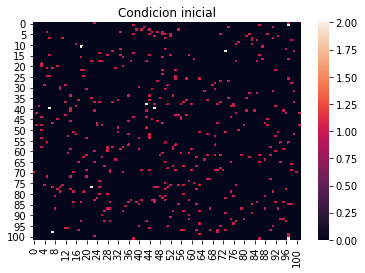

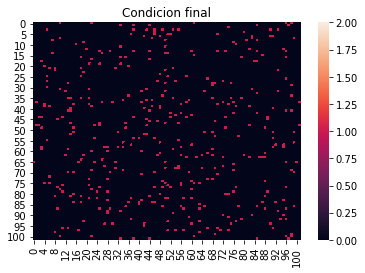

- 34.42705985307693 minutos de simulación -


In [1109]:
start_time = time.time()

N_pasos = 1200


d = 100

# Creamos una condicion inicial; una distribucion de particulas inicial

X0 = dist_uni(d,400)



# Replicamos las condiciones iniciales en el borde

X0 = func_act_CC(X0, d)

# Visualizamos la conddicion inicial

sns.heatmap(X0, vmin=0, vmax=2)
plt.title("Condicion inicial")
plt.savefig('Gillespie_Dif_{}.png'.format(nombre(0)))
plt.show()

# Iniciamos los vetores para las propensiones y probabilidades condicionadas

a = np.zeros((4,d + 2,d + 2))
P2 = np.zeros((4,d + 2,d + 2))
P3 = np.zeros((4))
P4 = np.zeros((d + 2))
#P5 = np.zeros((4,102))

# Iniciamos el tiempo

t = 0

# Calculamos las propensiones

a = actualizacion_as(a,X0, d)

# Lista para registrar los momentos de actualizacion

tiempos = [0]

# Calculo de las probabilidades iniciales

P2, P3 = act_probs(a,a0,P2,P3, d)


# Bucle Principal Monte Carlo

for i in range(0,N_pasos):
    t, X0, a, P2, P3 = paso_montecarlo(X0, a, t, P2, P3, d)
    tiempos.append(t)
    fig = plt.figure()
    sns.heatmap(X0, vmin=0, vmax=2)
    fig.savefig('Gillespie_Dif_{}.png'.format(nombre(i+1)))
    plt.close()
    #fig.show()
    
sns.heatmap(X0, vmin=0, vmax=2)
plt.title("Condicion final")
plt.show()

tiempo_Sim = (time.time() - start_time)/60.

print("- %s minutos de simulación -" % (tiempo_Sim))

#### $\approx 35$ minutos de simulación para una red de 100 x 100 nodos, en donde hay 400 partículas, para un tiempo de proceso de 0.8 unidades de tiempo (u.t.), con $D=1 L^2/u.t.$

In [1113]:
!mencoder "mf://*.png" -o Ani_Gill_Dif_FAST_06.mov -ovc lavc -lavcopts vcodec=msmpeg4v2:autoaspect:vbitrate=2160000:mbd=2:keyint=132:vqblur=1.0:cmp=2:subcmp=2:dia=2:o=mpv_flags=+mv0:last_pred=3 -fps 165;
                                        


MEncoder 1.3.0-4.2.1 (C) 2000-2016 MPlayer Team
224 audio & 451 video codecs

success: format: 16  data: 0x0 - 0x0
MF file format detected.
[mf] search expr: *.png
[mf] number of files: 1201 (9608)
[demux_mf] file type was not set! trying 'type=png'...
VIDEO:  [MPNG]  0x0  24bpp  25.000 fps    0.0 kbps ( 0.0 kbyte/s)
[V] filefmt:16  fourcc:0x474E504D  size:0x0  fps:25.000  ftime:=0.0400
Input fps will be interpreted as 165.000 instead.
libavcodec version 57.24.102 (internal)
Opening video filter: [expand osd=1]
Expand: -1 x -1, -1 ; -1, osd: 1, aspect: 0.000000, round: 1
Opening video decoder: [ffmpeg] FFmpeg's libavcodec codec family
Selected video codec: [ffpng] vfm: ffmpeg (FFmpeg PNG)
Could not find matching colorspace - retrying with -vf scale...
Opening video filter: [scale]
Movie-Aspect is undefined - no prescaling applied.
[swscaler @ 0x1071d0410]bicubic scaler, from rgba to yuv420p using MMXEXT
videocodec: libavcodec (432x288 fourcc=3234504d [MP42])
[VE_LAVC] High quality enco

Pos:   0.2s     39f ( 3%)  0.00fps Trem:   0min   1mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.2s     40f ( 3%)  0.00fps Trem:   0min   1mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.2s     41f ( 3%)  0.00fps Trem:   0min   1mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.3s     42f ( 3%)  0.00fps Trem:   0min   1mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.3s     43f ( 3%)  0.00fps Trem:   0min   1mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.3s     44f ( 3%)  0.00fps Trem:   0min   1mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071

Pos:   0.5s     85f ( 7%)  0.00fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.5s     86f ( 7%)  0.00fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.5s     87f ( 7%)  0.00fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.5s     88f ( 7%)  0.00fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.5s     89f ( 7%)  0.00fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.5s     90f ( 7%)  0.00fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071

Pos:   0.8s    131f (10%) 129.19fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.8s    132f (10%) 129.03fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.8s    133f (11%) 129.13fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.8s    134f (11%) 129.22fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.8s    135f (11%) 129.43fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   0.8s    136f (11%) 129.65fps Trem:   0min   0mb  A-V:0.000 [0:0]
[msmpeg4v2 @ 

Pos:   1.1s    183f (15%) 132.80fps Trem:   0min   0mb  A-V:0.000 [748:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.1s    184f (15%) 132.85fps Trem:   0min   0mb  A-V:0.000 [745:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.1s    185f (15%) 132.90fps Trem:   0min   0mb  A-V:0.000 [742:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.1s    186f (15%) 132.95fps Trem:   0min   0mb  A-V:0.000 [740:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.1s    187f (15%) 133.10fps Trem:   0min   0mb  A-V:0.000 [737:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.1s    188f (15%) 133.24fps Trem:   0min   0mb  A-V:0.000 [734:0]
[

Pos:   1.4s    232f (19%) 137.44fps Trem:   0min   0mb  A-V:0.000 [637:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.4s    233f (19%) 137.46fps Trem:   0min   0mb  A-V:0.000 [635:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.4s    234f (19%) 137.57fps Trem:   0min   0mb  A-V:0.000 [633:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.4s    235f (19%) 137.59fps Trem:   0min   0mb  A-V:0.000 [631:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.4s    236f (19%) 137.69fps Trem:   0min   0mb  A-V:0.000 [629:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.4s    237f (19%) 137.79fps Trem:   0min   0mb  A-V:0.000 [627:0]
[

Pos:   1.7s    280f (23%) 140.07fps Trem:   0min   0mb  A-V:0.000 [734:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.7s    281f (23%) 140.15fps Trem:   0min   0mb  A-V:0.000 [732:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.7s    282f (23%) 140.09fps Trem:   0min   0mb  A-V:0.000 [730:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.7s    283f (23%) 140.10fps Trem:   0min   0mb  A-V:0.000 [728:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.7s    284f (23%) 140.11fps Trem:   0min   0mb  A-V:0.000 [727:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   1.7s    285f (23%) 140.19fps Trem:   0min   0mb  A-V:0.000 [725:0]
[

Pos:   2.0s    327f (27%) 141.25fps Trem:   0min   0mb  A-V:0.000 [661:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.0s    328f (27%) 141.14fps Trem:   0min   0mb  A-V:0.000 [660:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.0s    329f (27%) 141.08fps Trem:   0min   0mb  A-V:0.000 [659:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.0s    330f (27%) 141.15fps Trem:   0min   0mb  A-V:0.000 [657:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.0s    331f (27%) 141.15fps Trem:   0min   0mb  A-V:0.000 [656:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.0s    332f (27%) 141.16fps Trem:   0min   0mb  A-V:0.000 [655:0]
[

Pos:   2.3s    373f (31%) 142.15fps Trem:   0min   0mb  A-V:0.000 [608:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.3s    374f (31%) 142.15fps Trem:   0min   0mb  A-V:0.000 [607:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.3s    375f (31%) 142.15fps Trem:   0min   0mb  A-V:0.000 [606:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.3s    376f (31%) 142.15fps Trem:   0min   0mb  A-V:0.000 [605:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.3s    377f (31%) 142.21fps Trem:   0min   0mb  A-V:0.000 [604:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.3s    378f (31%) 142.32fps Trem:   0min   0mb  A-V:0.000 [603:0]
[

Pos:   2.5s    420f (34%) 143.49fps Trem:   0min   0mb  A-V:0.000 [677:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.6s    421f (35%) 143.49fps Trem:   0min   0mb  A-V:0.000 [676:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.6s    422f (35%) 143.39fps Trem:   0min   0mb  A-V:0.000 [675:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.6s    423f (35%) 143.44fps Trem:   0min   0mb  A-V:0.000 [674:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.6s    424f (35%) 143.49fps Trem:   0min   0mb  A-V:0.000 [673:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.6s    425f (35%) 143.48fps Trem:   0min   0mb  A-V:0.000 [672:0]
[

Pos:   2.8s    469f (39%) 144.84fps Trem:   0min   0mb  A-V:0.000 [630:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.8s    470f (39%) 144.84fps Trem:   0min   0mb  A-V:0.000 [629:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.9s    471f (39%) 144.88fps Trem:   0min   0mb  A-V:0.000 [628:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.9s    472f (39%) 144.83fps Trem:   0min   0mb  A-V:0.000 [627:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.9s    473f (39%) 144.91fps Trem:   0min   0mb  A-V:0.000 [626:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   2.9s    474f (39%) 144.95fps Trem:   0min   0mb  A-V:0.000 [625:0]
[

Pos:   3.1s    517f (43%) 145.47fps Trem:   0min   0mb  A-V:0.000 [591:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.1s    518f (43%) 145.51fps Trem:   0min   0mb  A-V:0.000 [590:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.1s    519f (43%) 145.54fps Trem:   0min   0mb  A-V:0.000 [590:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.2s    520f (43%) 145.54fps Trem:   0min   0mb  A-V:0.000 [589:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.2s    521f (43%) 145.57fps Trem:   0min   0mb  A-V:0.000 [588:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.2s    522f (43%) 145.61fps Trem:   0min   0mb  A-V:0.000 [588:0]
[

Pos:   3.4s    563f (46%) 146.01fps Trem:   0min   0mb  A-V:0.000 [645:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.4s    564f (46%) 145.96fps Trem:   0min   0mb  A-V:0.000 [644:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.4s    565f (47%) 145.88fps Trem:   0min   0mb  A-V:0.000 [644:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.4s    566f (47%) 145.88fps Trem:   0min   0mb  A-V:0.000 [643:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.4s    567f (47%) 145.76fps Trem:   0min   0mb  A-V:0.000 [642:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.4s    568f (47%) 145.75fps Trem:   0min   0mb  A-V:0.000 [642:0]
[

Pos:   3.7s    612f (50%) 144.92fps Trem:   0min   0mb  A-V:0.000 [613:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.7s    613f (51%) 144.92fps Trem:   0min   0mb  A-V:0.000 [612:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.7s    614f (51%) 144.91fps Trem:   0min   0mb  A-V:0.000 [612:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.7s    615f (51%) 144.91fps Trem:   0min   0mb  A-V:0.000 [611:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.7s    616f (51%) 144.87fps Trem:   0min   0mb  A-V:0.000 [610:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   3.7s    617f (51%) 144.80fps Trem:   0min   0mb  A-V:0.000 [610:0]
[

Pos:   4.0s    661f (55%) 144.07fps Trem:   0min   0mb  A-V:0.000 [647:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.0s    662f (55%) 143.98fps Trem:   0min   0mb  A-V:0.000 [654:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.0s    663f (55%) 143.76fps Trem:   0min   0mb  A-V:0.000 [654:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.0s    664f (55%) 143.47fps Trem:   0min   0mb  A-V:0.000 [654:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.0s    665f (55%) 143.47fps Trem:   0min   0mb  A-V:0.000 [653:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.0s    666f (55%) 143.35fps Trem:   0min   0mb  A-V:0.000 [653:0]
[

Pos:   4.3s    708f (58%) 139.92fps Trem:   0min   0mb  A-V:0.000 [628:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.3s    709f (58%) 139.92fps Trem:   0min   0mb  A-V:0.000 [627:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.3s    710f (59%) 139.79fps Trem:   0min   0mb  A-V:0.000 [627:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.3s    711f (59%) 139.77fps Trem:   0min   0mb  A-V:0.000 [626:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.3s    712f (59%) 139.74fps Trem:   0min   0mb  A-V:0.000 [626:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.3s    713f (59%) 139.75fps Trem:   0min   0mb  A-V:0.000 [625:0]
[

Pos:   4.6s    755f (62%) 139.43fps Trem:   0min   0mb  A-V:0.000 [603:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.6s    756f (62%) 139.43fps Trem:   0min   0mb  A-V:0.000 [603:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.6s    757f (63%) 139.44fps Trem:   0min   0mb  A-V:0.000 [602:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.6s    758f (63%) 139.36fps Trem:   0min   0mb  A-V:0.000 [601:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.6s    759f (63%) 139.39fps Trem:   0min   0mb  A-V:0.000 [601:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.6s    760f (63%) 139.42fps Trem:   0min   0mb  A-V:0.000 [600:0]
[

Pos:   4.9s    801f (66%) 139.96fps Trem:   0min   0mb  A-V:0.000 [640:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.9s    802f (66%) 139.94fps Trem:   0min   0mb  A-V:0.000 [640:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.9s    803f (66%) 139.94fps Trem:   0min   0mb  A-V:0.000 [639:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.9s    804f (66%) 139.95fps Trem:   0min   0mb  A-V:0.000 [639:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.9s    805f (67%) 139.98fps Trem:   0min   0mb  A-V:0.000 [638:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   4.9s    806f (67%) 140.00fps Trem:   0min   0mb  A-V:0.000 [638:0]
[

Pos:   5.2s    850f (70%) 140.87fps Trem:   0min   0mb  A-V:0.000 [617:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.2s    851f (70%) 140.87fps Trem:   0min   0mb  A-V:0.000 [616:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.2s    852f (70%) 140.90fps Trem:   0min   0mb  A-V:0.000 [616:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.2s    853f (71%) 140.88fps Trem:   0min   0mb  A-V:0.000 [615:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.2s    854f (71%) 140.88fps Trem:   0min   0mb  A-V:0.000 [615:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.2s    855f (71%) 140.90fps Trem:   0min   0mb  A-V:0.000 [614:0]
[

Pos:   5.4s    894f (74%) 139.43fps Trem:   0min   0mb  A-V:0.000 [598:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.4s    895f (74%) 139.45fps Trem:   0min   0mb  A-V:0.000 [597:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.4s    896f (74%) 139.48fps Trem:   0min   0mb  A-V:0.000 [597:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.4s    897f (74%) 139.50fps Trem:   0min   0mb  A-V:0.000 [597:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.4s    898f (74%) 139.55fps Trem:   0min   0mb  A-V:0.000 [596:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.4s    899f (74%) 139.57fps Trem:   0min   0mb  A-V:0.000 [596:0]
[

Pos:   5.7s    941f (78%) 140.99fps Trem:   0min   0mb  A-V:0.000 [629:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.7s    942f (78%) 141.02fps Trem:   0min   0mb  A-V:0.000 [629:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.7s    943f (78%) 141.06fps Trem:   0min   0mb  A-V:0.000 [628:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.7s    944f (78%) 141.09fps Trem:   0min   0mb  A-V:0.000 [628:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.7s    945f (78%) 141.13fps Trem:   0min   0mb  A-V:0.000 [628:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   5.7s    946f (78%) 141.17fps Trem:   0min   0mb  A-V:0.000 [627:0]
[

Pos:   6.0s    987f (82%) 142.51fps Trem:   0min   0mb  A-V:0.000 [611:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.0s    988f (82%) 142.53fps Trem:   0min   0mb  A-V:0.000 [610:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.0s    989f (82%) 142.55fps Trem:   0min   0mb  A-V:0.000 [610:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.0s    990f (82%) 142.59fps Trem:   0min   0mb  A-V:0.000 [610:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.0s    991f (82%) 142.61fps Trem:   0min   0mb  A-V:0.000 [609:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.0s    992f (82%) 142.65fps Trem:   0min   0mb  A-V:0.000 [609:0]
[

Pos:   6.3s   1033f (86%) 143.79fps Trem:   0min   0mb  A-V:0.000 [594:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.3s   1034f (86%) 143.81fps Trem:   0min   0mb  A-V:0.000 [593:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.3s   1035f (86%) 143.83fps Trem:   0min   0mb  A-V:0.000 [593:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.3s   1036f (86%) 143.87fps Trem:   0min   0mb  A-V:0.000 [593:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.3s   1037f (86%) 143.91fps Trem:   0min   0mb  A-V:0.000 [592:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.3s   1038f (86%) 143.93fps Trem:   0min   0mb  A-V:0.000 [592:0]
[

Pos:   6.6s   1082f (90%) 144.31fps Trem:   0min   0mb  A-V:0.000 [621:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.6s   1083f (90%) 144.30fps Trem:   0min   0mb  A-V:0.000 [621:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.6s   1084f (90%) 144.28fps Trem:   0min   0mb  A-V:0.000 [620:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.6s   1085f (90%) 144.28fps Trem:   0min   0mb  A-V:0.000 [620:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.6s   1086f (90%) 144.28fps Trem:   0min   0mb  A-V:0.000 [620:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.6s   1087f (90%) 144.28fps Trem:   0min   0mb  A-V:0.000 [619:0]
[

Pos:   6.8s   1127f (93%) 144.28fps Trem:   0min   0mb  A-V:0.000 [605:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.8s   1128f (93%) 144.28fps Trem:   0min   0mb  A-V:0.000 [605:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.8s   1129f (94%) 144.28fps Trem:   0min   0mb  A-V:0.000 [605:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.8s   1130f (94%) 144.28fps Trem:   0min   0mb  A-V:0.000 [604:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.9s   1131f (94%) 144.28fps Trem:   0min   0mb  A-V:0.000 [604:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   6.9s   1132f (94%) 144.28fps Trem:   0min   0mb  A-V:0.000 [604:0]
[

Pos:   7.1s   1173f (97%) 144.48fps Trem:   0min   0mb  A-V:0.000 [591:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   7.1s   1174f (97%) 144.47fps Trem:   0min   0mb  A-V:0.000 [590:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   7.1s   1175f (97%) 144.47fps Trem:   0min   0mb  A-V:0.000 [590:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   7.1s   1176f (97%) 144.47fps Trem:   0min   0mb  A-V:0.000 [590:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   7.1s   1177f (98%) 144.47fps Trem:   0min   0mb  A-V:0.000 [589:0]
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.format is not set
[msmpeg4v2 @ 0x1071b6fe0]AVFrame.width or height is not set
Pos:   7.1s   1178f (98%) 144.49fps Trem:   0min   0mb  A-V:0.000 [589:0]
[

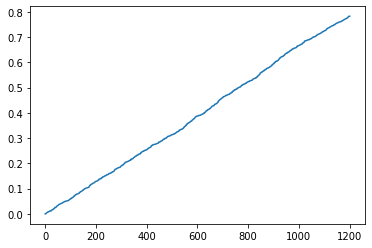

In [1114]:
plt.plot(tiempos)